# Lecture 3

The usual preamble....

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


One new package today:
 * [daft](http://daft-pgm.org) (again: `pip install daft`), from Dan Foreman-Mackey, for drawing graphical probabilistic models.  (See below.)

In [2]:
import corner
import daft
import pystan
import scipy.special as sp
import scipy.signal as ss
import scipy.stats as st
import seaborn as sns

In [3]:
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')

## Stacking, Semi-Stacking

This has come up a lot in the discussions this week.  Here is an example of a "hierarchical" model and its interpretation as (semi)stacking.  I first created this model to convince [Dave Tsang](https://www.astro.umd.edu/~dtsang/) that it might be fruitful to search for resonant shattering flares using semi-stacking; you can see the toy model I constructed, which is similar to this one, at https://github.com/farr/ShatteringFlares.  

For some real work on semi-stacking that I have been involved in, see [Lieu, et al. (2017)](https://arxiv.org/abs/1701.00478).

* Discussion

In [4]:
def exp_sigmoid(x, x0, dx):
    return 1.0/(1.0 + exp(-(x-x0)/dx))
def flare_profile(ts, tcent, tscale):
    return exp_sigmoid(ts, tcent, tscale/10.0)*(1.0 - exp_sigmoid(ts, tcent, tscale))

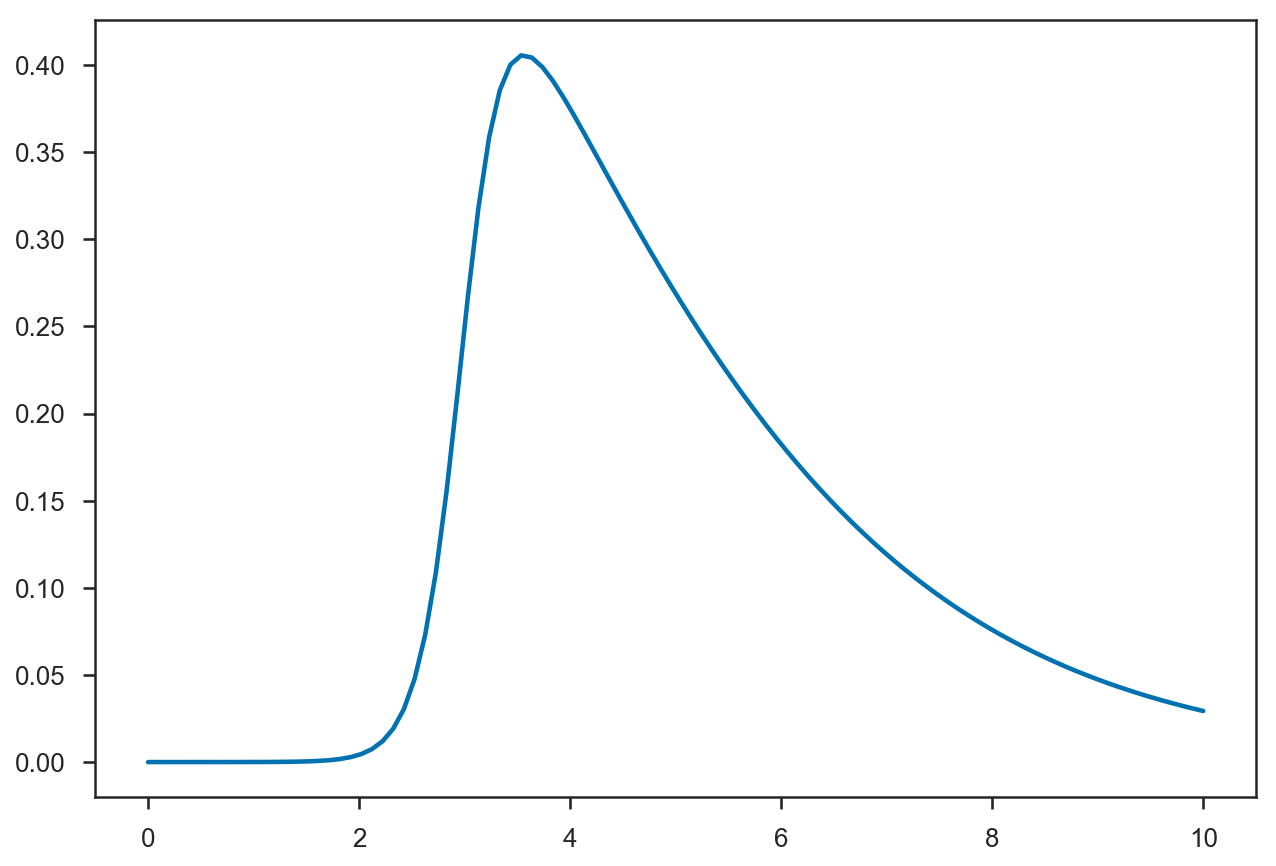

In [5]:
ts = linspace(0, 10, 100)
plot(ts, flare_profile(ts, 3.0, 2.0))

In [6]:
def draw_poisson_lc(ts, bg_rate, A, t0, dt):
    total_rate = bg_rate + A*flare_profile(ts, t0, dt)
    cts = 0.5*diff(ts)*(total_rate[:-1] + total_rate[1:])
    return np.random.poisson(lam=cts)

<Container object of 3 artists>

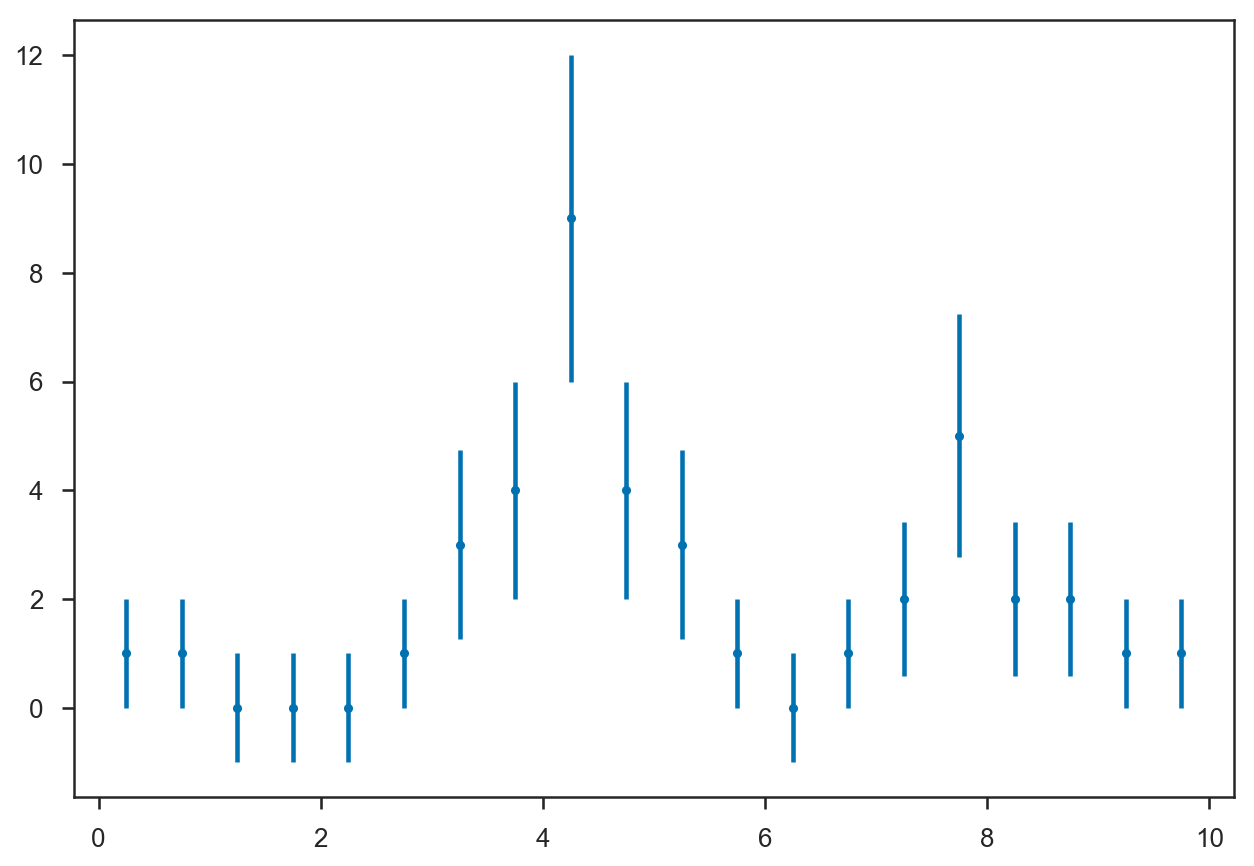

In [7]:
ts = linspace(0, 10, 21)
cts = draw_poisson_lc(ts, 1.0, 20.0, 3.0, 2.0)
errorbar(0.5*(ts[:-1]+ts[1:]), cts, where(cts < 1, 1.0, sqrt(cts)), fmt='.')

The parameters of a flare are then $A$, the amplitude, $t_0$ the peak time, and $\tau$, the decay timescale.  If we imagine these come from a population, then we can conduct a hierarchical analysis.

Here is a daft model of our population:

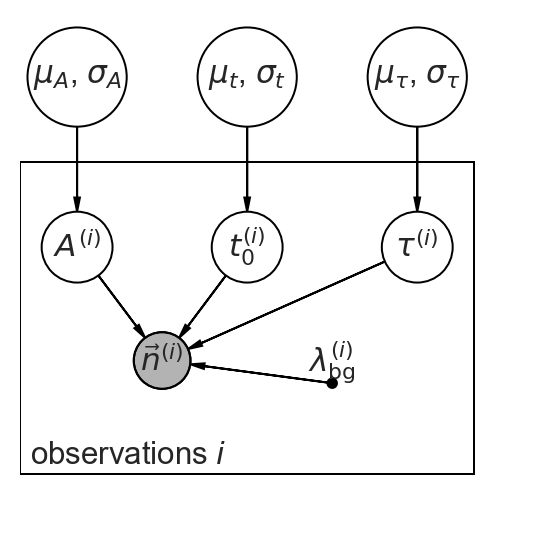

In [8]:
pgm = daft.PGM([4.5, 4.5], origin=[0,-1])
pgm.add_node(daft.Node("amp_pop", r'$\mu_A$, $\sigma_A$', 0.5, 3, scale=1.75))
pgm.add_node(daft.Node('time_pop', r'$\mu_t$, $\sigma_t$', 2, 3, scale=1.75))
pgm.add_node(daft.Node('tau_pop', r'$\mu_\tau$, $\sigma_\tau$', 3.5, 3, scale=1.75))
pgm.add_node(daft.Node('amp', r'$A^{(i)}$', 0.5, 1.5, scale=1.25))
pgm.add_node(daft.Node('time', r'$t_0^{(i)}$', 2, 1.5, scale=1.25))
pgm.add_node(daft.Node('scale', r'$\tau^{(i)}$', 3.5, 1.5, scale=1.25))
pgm.add_node(daft.Node('counts', r'$\vec{n}^{(i)}$', 1.25, 0.5, observed=True))
pgm.add_node(daft.Node('background', r'$\lambda_\mathrm{bg}^{(i)}$', 2.75, 0.3, fixed=True))
pgm.add_plate(daft.Plate([0.0, -0.5, 4.0, 2.75], label=r'observations $i$'))
pgm.add_edge("amp_pop", "amp")
pgm.add_edge('time_pop', 'time')
pgm.add_edge('tau_pop', 'scale')
pgm.add_edge('amp', 'counts')
pgm.add_edge('time', 'counts')
pgm.add_edge('scale', 'counts')
pgm.add_edge('background', 'counts')
pgm.render()

Now we draw some "observations":

In [40]:
mu_A = log(4.0)
sigma_A = 0.5
mu_t = 0.0
sigma_t = 2.0
mu_tau = log(1.0)
sigma_tau = 0.25
mu_bg = log(1.0)
sigma_bg = 0.25

no = 100
nbin = 20
ts_bin = linspace(-5, 5, nbin+1)
bgs = []
As = []
ts = []
taus = []
counts = []
for i in range(no):
    bg = random.lognormal(mu_bg, sigma_bg) 
    A = random.lognormal(mu_A, sigma_A)
    t = random.normal(mu_t, sigma_t)
    tau = random.lognormal(mu_tau, sigma_tau)
    
    cts = draw_poisson_lc(ts_bin, bg, A, t, tau)
    
    bgs.append(bg)
    As.append(A)
    ts.append(t)
    taus.append(tau)
    
    counts.append(cts)

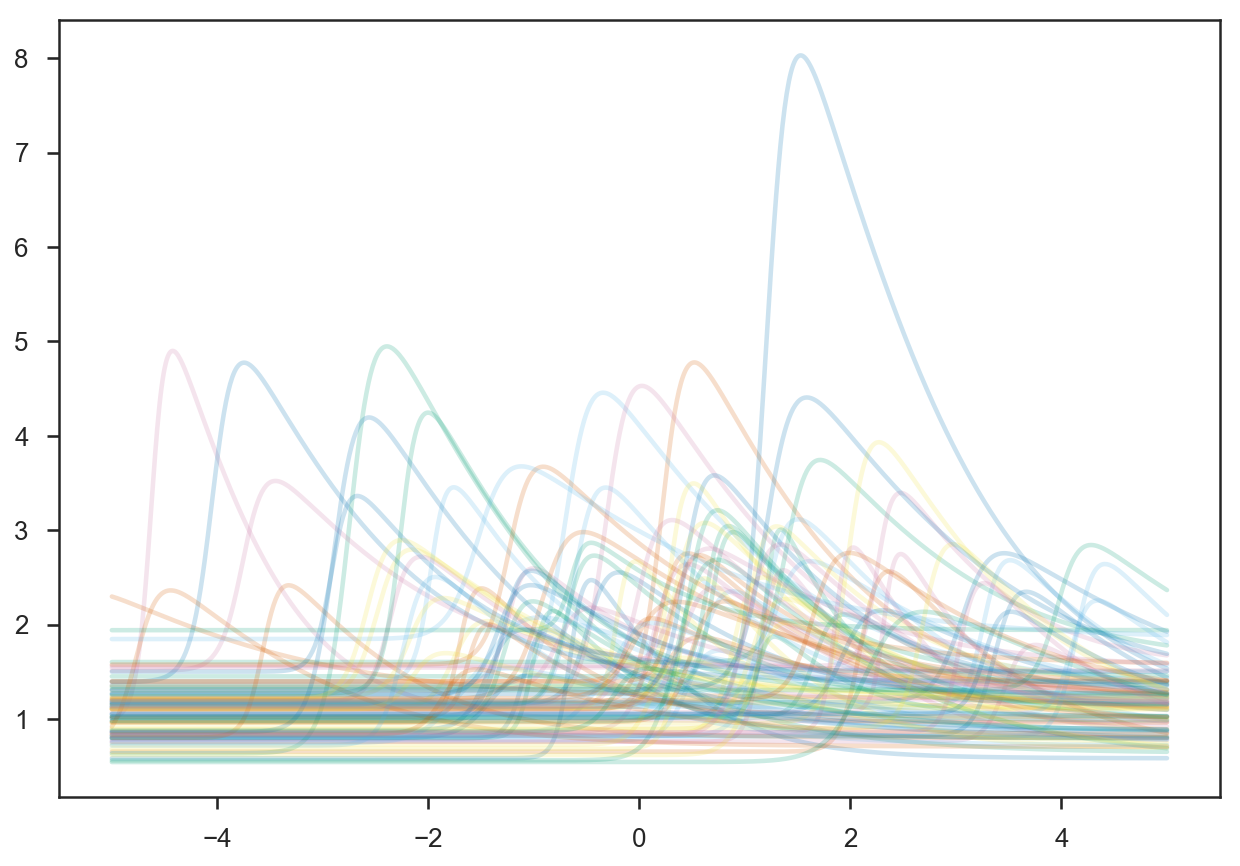

In [41]:
t = linspace(-5, 5, 1000)
for i in range(no):
    plot(t, bgs[i]+As[i]*flare_profile(t, ts[i], taus[i]), alpha=0.2)

In [16]:
model = pystan.StanModel(file='hierarchical_shattering.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6a8877b13036685abaf485ee54e1d1e7 NOW.


In [42]:
data = {
    'no': no,
    'nc': nbin,
    'ts_bin': ts_bin,
    'bg_rate': bgs,
    'counts': counts
}

In [43]:
fit = model.sampling(data=data)
fit

Inference for Stan model: anon_model_6a8877b13036685abaf485ee54e1d1e7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_A            1.16    0.03   0.28    0.6   0.97   1.15   1.35   1.72     68   1.05
sigma_A         0.45    0.03   0.22   0.06   0.29   0.46   0.61   0.87     62   1.06
mu_t           -0.43    0.05   0.58  -1.57  -0.82  -0.43  -0.05   0.67    157   1.03
sigma_t          2.3    0.07    0.6   1.45   1.91   2.18   2.55   3.95     84   1.03
mu_tau          0.27    0.03   0.31  -0.37   0.06   0.27   0.48   0.89     94   1.04
sigma_tau       0.56    0.03   0.31   0.04   0.31   0.56   0.77   1.19    110   1.04
norm_As[0]     -0.14    0.06   0.93  -1.93  -0.78  -0.13   0.47   1.77    244   1.02
norm_As[1]     -0.42    0.04   0.92  -2.19  -1.03  -0.41   0.16   1.49    526   1.01
norm_As[2]       0.6    0.05   0.88  -1.21  -0

In [44]:
chains = fit.extract(permuted=True)

Corner plot of the population parameters:

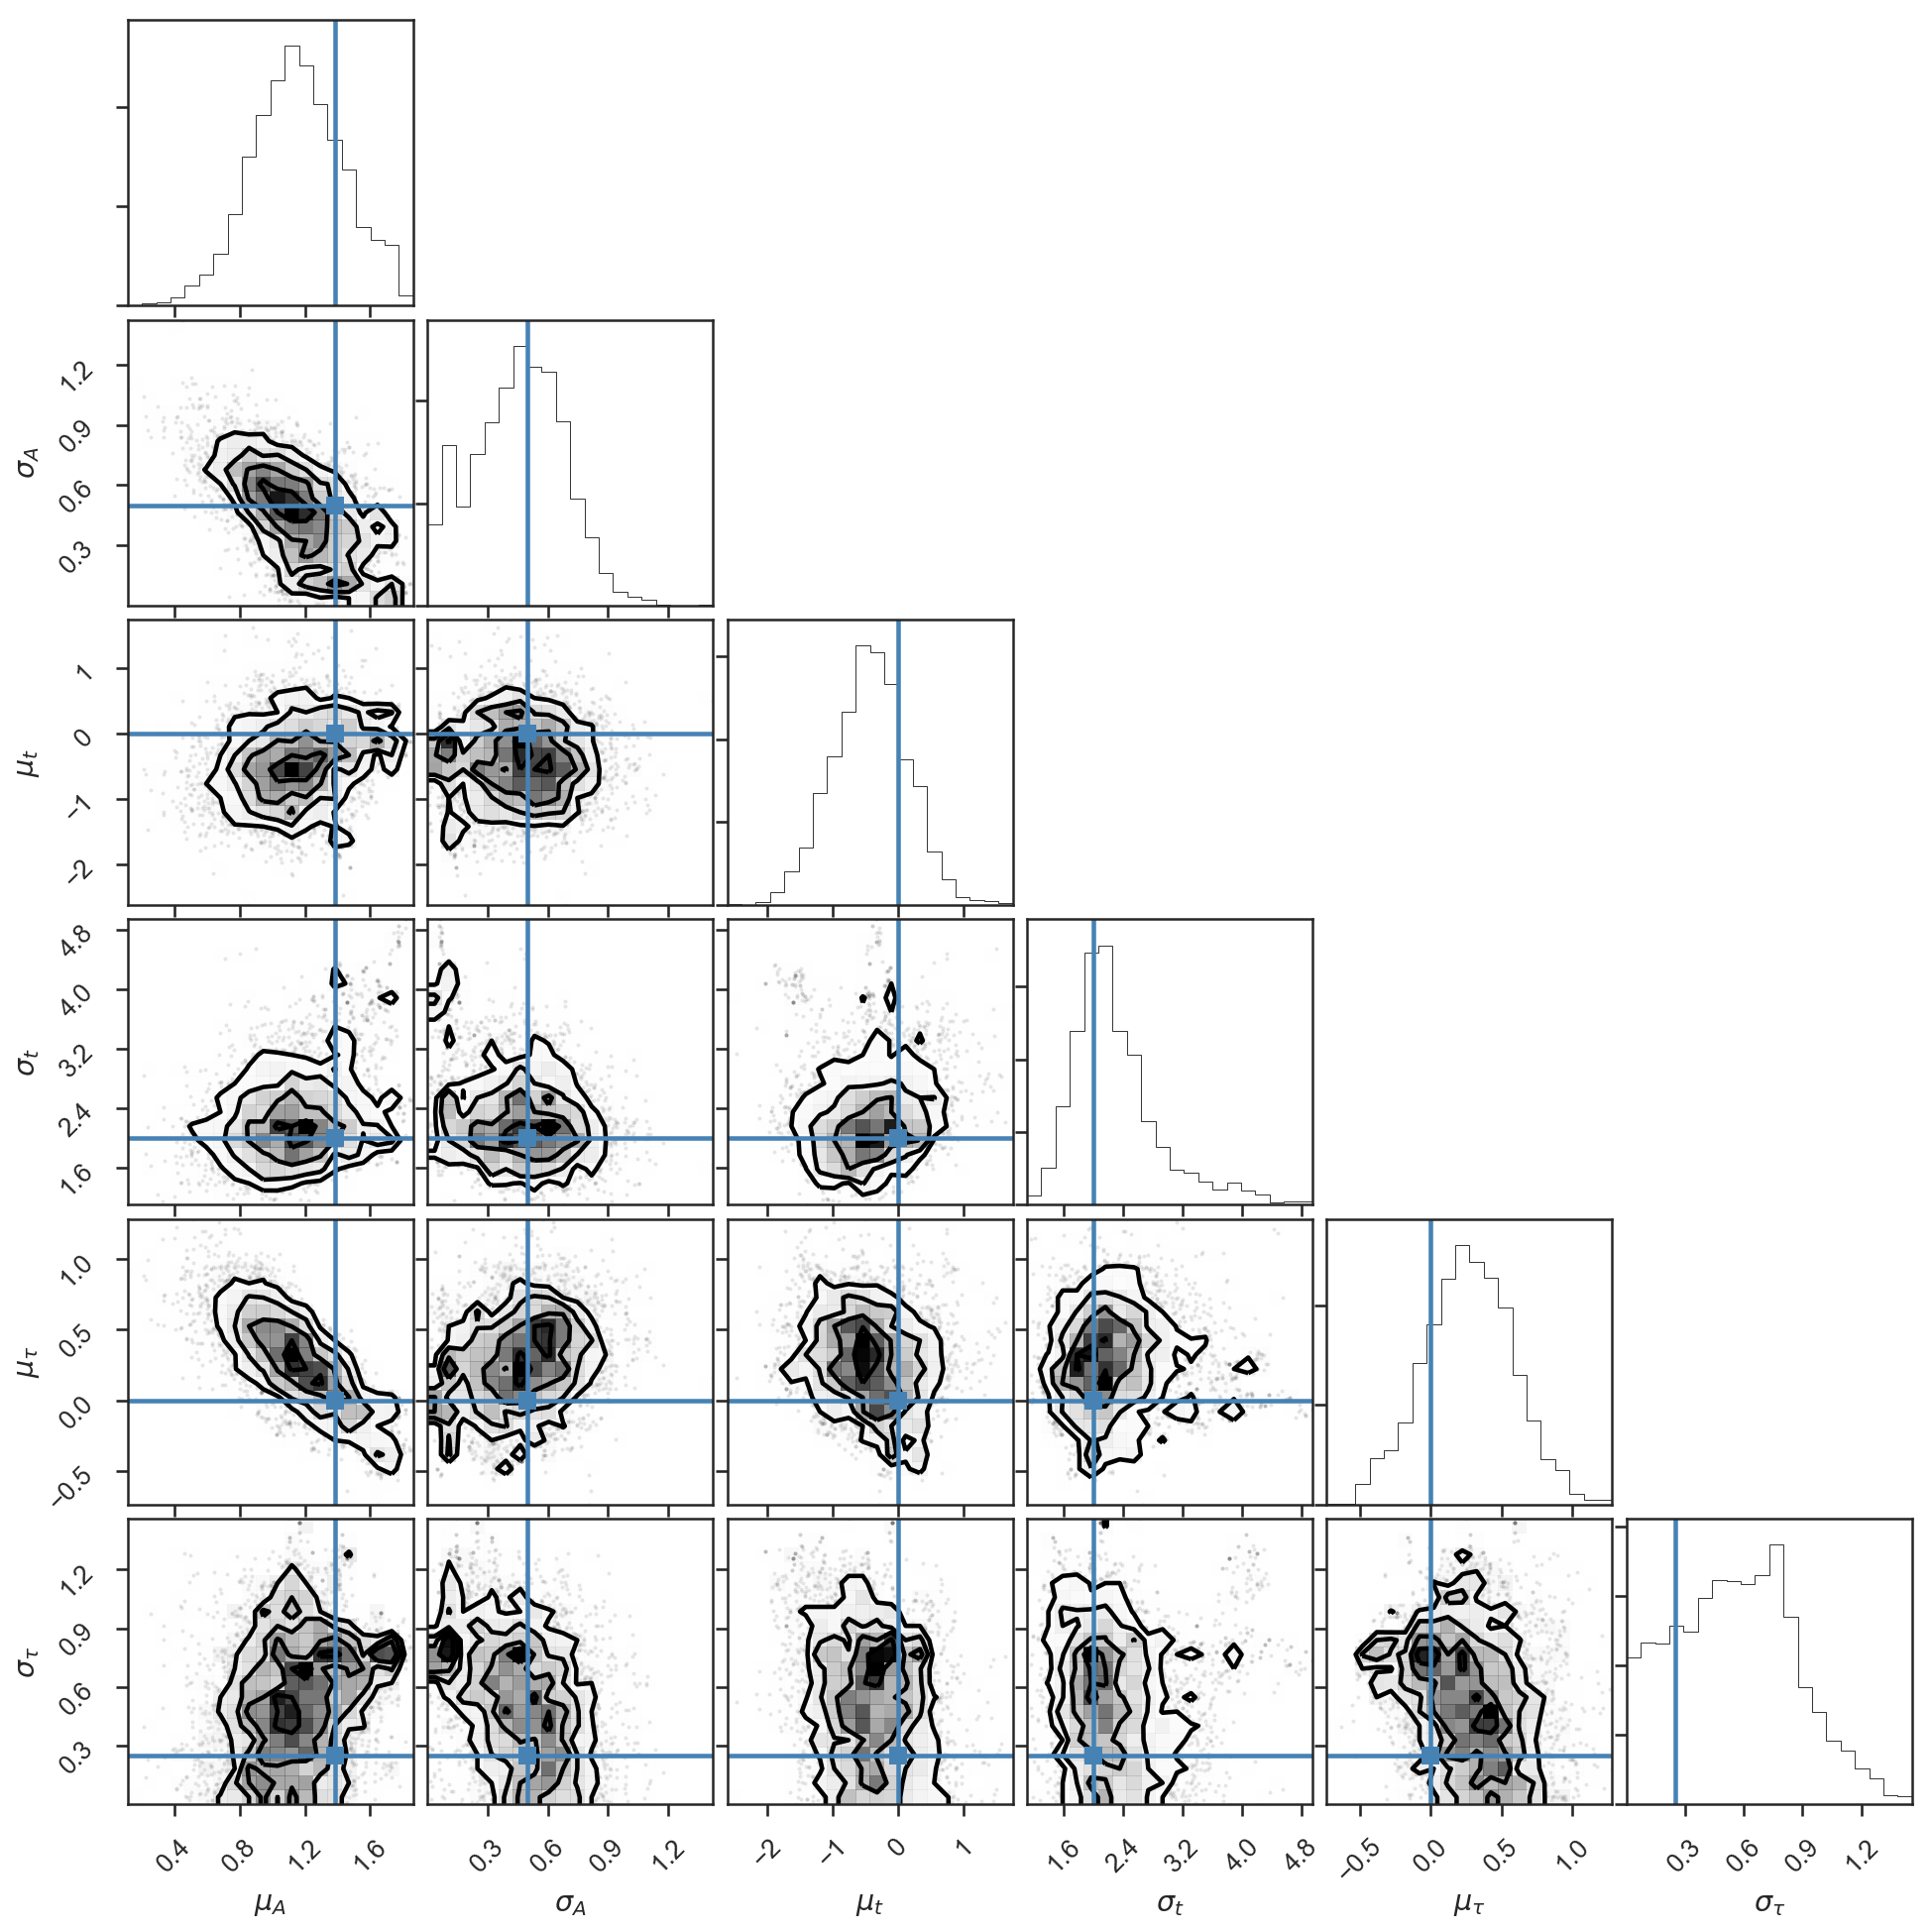

In [45]:
corner.corner(
    column_stack([chains[key] for key in ['mu_A', 'sigma_A', 'mu_t', 'sigma_t', 'mu_tau', 'sigma_tau']]),
    labels=[r'$\mu_A$', r'$\sigma_A$', r'$\mu_t$', r'$\sigma_t$', r'$\mu_\tau$', r'$\sigma_\tau$'],
    truths=[mu_A, sigma_A, mu_t, sigma_t, mu_tau, sigma_tau]
);

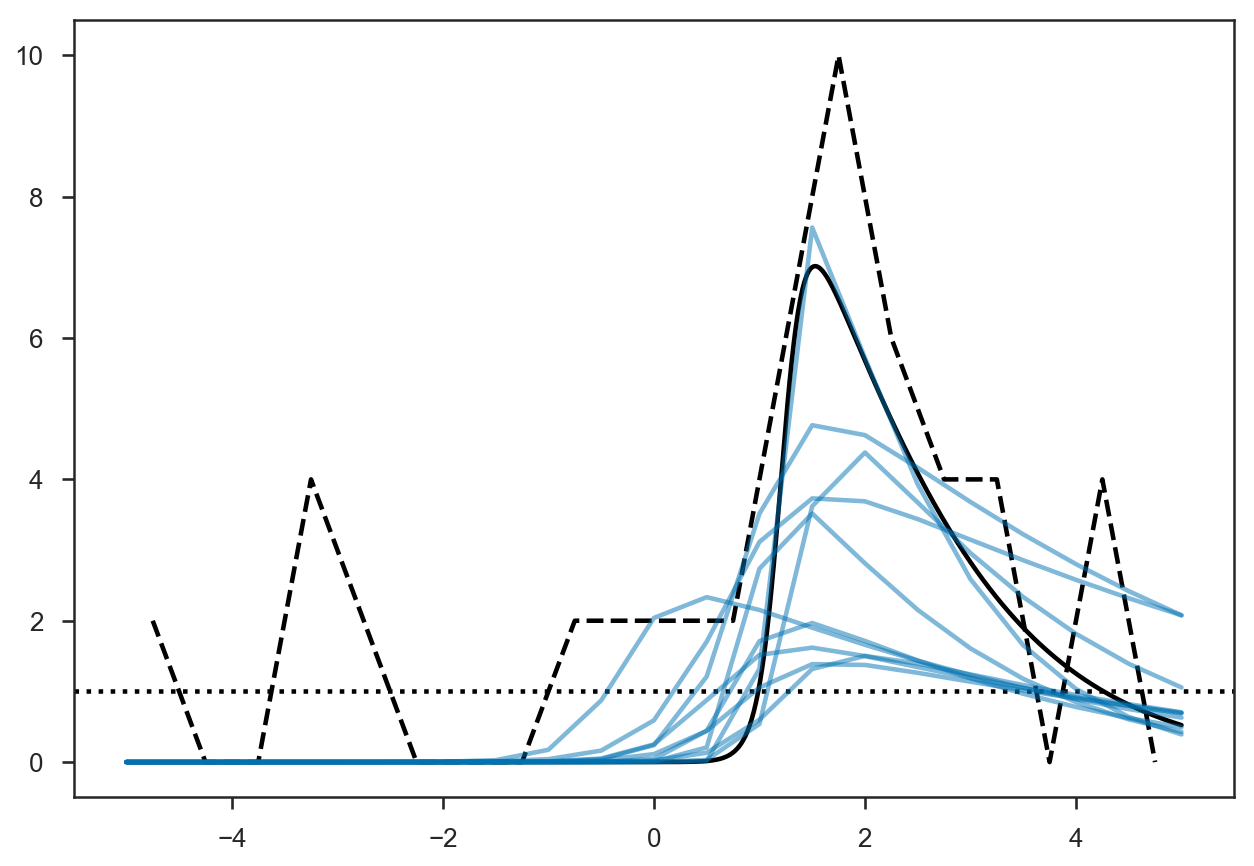

In [89]:
i = argmax(As)
plot(t, As[i]*flare_profile(t, ts[i], taus[i]), '-k')
plot(0.5*(ts_bin[:-1] + ts_bin[1:]), counts[i]/(diff(ts_bin)), '--k')
axhline(bgs[i], ls=':', color='k')
for j in range(10):
    k = randint(chains['flare'].shape[0])
    plot(ts_bin, chains['flare'][k,i,:], alpha=0.5, color=sns.color_palette()[0])

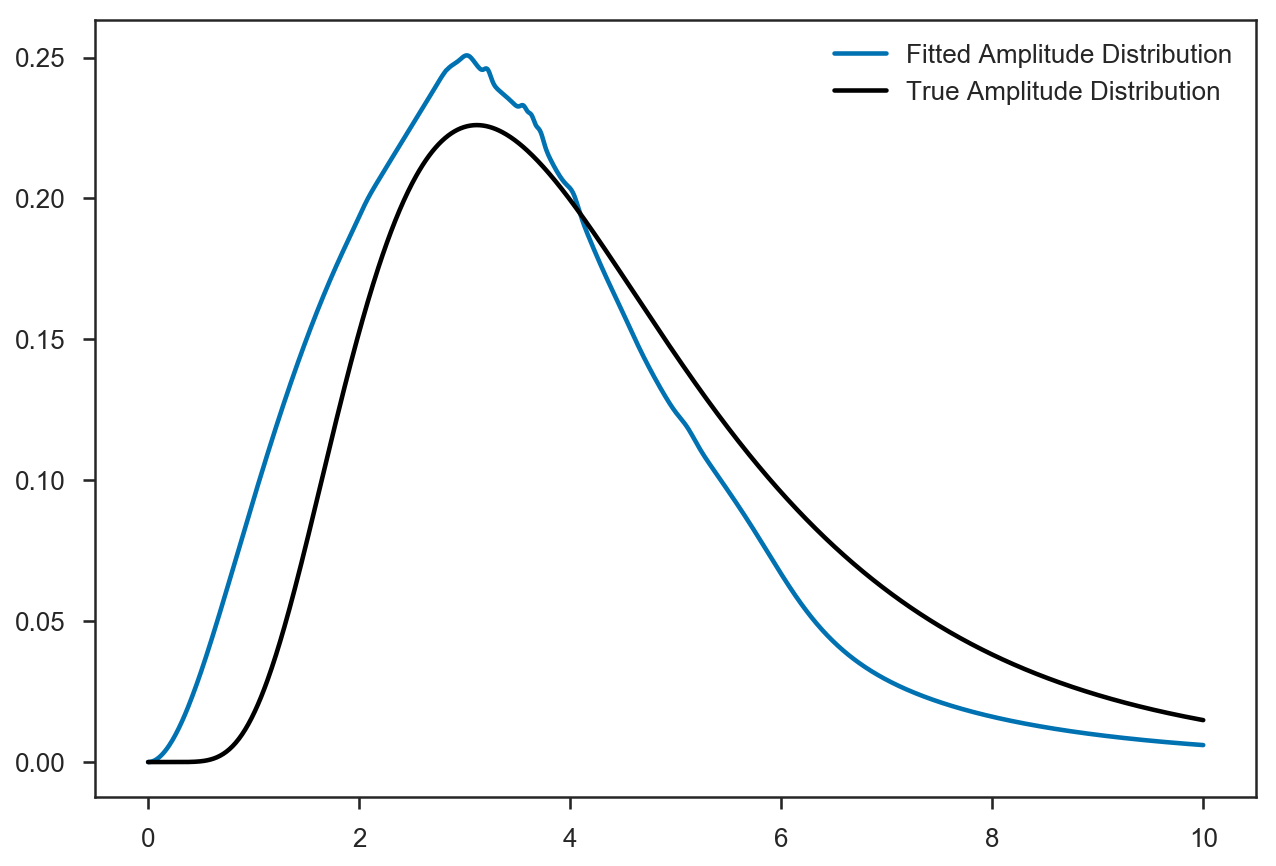

In [55]:
def population_amplitude(As, mu_A, sigma_A):
    return st.lognorm(sigma_A, scale=exp(mu_A)).pdf(As)
A = linspace(0, 10, 1000)
pop_amps = zeros(1000)
for mu, s in zip(chains['mu_A'], chains['sigma_A']):
    pop_amps += population_amplitude(A, mu, s)
pop_amps /= len(chains['mu_A']) # Take Average
plot(A, pop_amps, label='Fitted Amplitude Distribution')
plot(A, st.lognorm(sigma_A, scale=exp(mu_A)).pdf(A), '-k', label='True Amplitude Distribution')
legend(loc='best')

## Populations

Discussion/derivation of the "fundamental equation of populations":
$$
p\left( \left\{ d^{(i)}, \boldsymbol{\theta^{(i)}} \right\} \mid \boldsymbol{\lambda} \right) = \left[ \prod_{i} P_\mathrm{det}\left( d^{(i)} \mid \boldsymbol{\lambda} \right) p\left( d^{(i)} | \boldsymbol{\theta}^{(i)} \right) \frac{\mathrm{d} N}{\mathrm{d} \boldsymbol{\theta}}\left( \boldsymbol{\theta}^{(i)} \mid \boldsymbol{\lambda} \right) \right] \exp\left[ - \int \mathrm{d} d \mathrm{d}\boldsymbol{\theta} P_\mathrm{det}\left( d \mid \boldsymbol \lambda \right) p\left( d \mid \boldsymbol{\theta} \right) \frac{\mathrm{d}N}{\mathrm{d} \boldsymbol{\theta}}\left( \boldsymbol{\theta} \mid \lambda \right) \right]
$$

Since I didn't get a chance to talk about this due to time constraints, I will try to write something here.  Let's work up to that equation.  First, consider trying to measure a rate function parameterised by some parameters $\boldsymbol{\lambda}$:
$$
\frac{\mathrm{d} N}{\mathrm{d} \boldsymbol{\theta}}\left( \boldsymbol{\theta} \mid \boldsymbol{\lambda} \right)
$$
from a large number of measurements of $\boldsymbol{\theta}$.  What is the appropriate likelihood to use for the measurements?  Well, if we are willing to assume 
 1. The values of $\boldsymbol{\theta}$ that we measure don't "pile up" (that is, as we shrink some range of $\boldsymbol{\theta}$, $\mathrm{d} \boldsymbol{\theta}$, there will eventually be zero or one measurement in the range).
 1. The number of $\boldsymbol{\theta}$ measured within a certain range is independent of the number of $\boldsymbol{\theta}$ measured outside it.  (This is not the case if we are measuring from only a finite "pool" of possible events: seeing one within a range $\mathrm{d} \boldsymbol{\theta}$ means there is one fewer from the pool to go in other ranges.)
 1. Within any particular range of $\boldsymbol{\theta}$ the number of values measured follows a Poisson distribution.

Then our samples come from an "inhomogeneous Poisson process" (inhomogeneous because the rate, $\mathrm{d} N/\mathrm{d} \boldsymbol{\theta}$, is not constant, Poisson reflects the properties above, and process because $\boldsymbol{\theta}$ is a continuous variable and can take on uncountably many different values).  The likelihood for such a process follows from considering a large number of short intervals; each short interval contains either zero or one event, and the probabilities are Poisson.  The events in each interval are independent of any other interval's events.  Thus, the likelihood is a product of $\mathrm{Poisson}(0)$ over intervals without a measurement (here indexed by $i$) and $\mathrm{Poisson}(1)$ over intervals with a measurement (here indexed by $j$):
$$
p\left( \left\{ \boldsymbol{\theta}^{(i)} \right\} \mid \lambda \right) \prod_i \mathrm{d} \boldsymbol{\theta}_i = \prod_j \exp\left( - \frac{\mathrm{d} N}{\mathrm{d} \boldsymbol{\theta} } \left( \boldsymbol{\theta_j} \mid \boldsymbol{\lambda} \right) \mathrm{d} \boldsymbol{\theta}_j \right) \prod_i \left[ \frac{\mathrm{d} N}{\mathrm{d} \boldsymbol{\theta} } \left( \boldsymbol{\theta^{(i)}} \mid \boldsymbol{\lambda} \right) \mathrm{d} \boldsymbol{\theta}_i \exp\left( - \frac{\mathrm{d} N}{\mathrm{d} \boldsymbol{\theta} } \left( \boldsymbol{\theta}^{(i)} \mid \boldsymbol{\lambda} \right) \mathrm{d} \boldsymbol{\theta}_i \right) \right]
$$
($j$ indexes intervals where there are no samples, and $i$ indexes the (finite number) of intervals where there are samples.)  Taking the limit as the width of the intervals goes to zero (the number of non-measurement intervals goes to infinity, but the number of measurement intervals is fixed by the number of measurements) the exponentials combine and we can cancel the $\mathrm{d} \boldsymbol{\theta}_i$ terms because the likelihood should be a density, yielding
$$
p\left( \left\{ \boldsymbol{\theta}^{(j)} \right\} \mid \lambda \right) = \prod_j \left[ \frac{\mathrm{d} N}{\mathrm{d} \boldsymbol{\theta}} \left( \boldsymbol{\theta}^{(j)} \mid \boldsymbol{\lambda} \right) \right] \exp\left( - \int \mathrm{d} \boldsymbol{\theta} \frac{\mathrm{d} N}{\mathrm{d} \boldsymbol{\theta}}\left(\boldsymbol{\theta} \mid \boldsymbol{\lambda}\right) \right) = \prod_j \left[ \frac{\mathrm{d} N}{\mathrm{d} \boldsymbol{\theta}} \left( \boldsymbol{\theta}^{(j)} \mid \boldsymbol{\lambda} \right) \right] \exp\left( - N\left(\boldsymbol{\lambda}\right) \right)
$$
Those who notice the resemblance to the Poisson likelihood may be asking "where is the factorial?"  It is not needed here because the measurements, $\theta^{(j)}$, are *distinguishable*, unlike for the standrad Poisson likelihood (see also the discussion of "time ordering" in [Farr, et al. (2015)](https://ui.adsabs.harvard.edu/#abs/2015PhRvD..91b3005F/abstract)).

We will now do a worked example, beginning with this equation and adding various effects to our model until we arrive at the first equation above.

### A Worked Example

Let's try fitting some rates.  Suppose a hypothetical LIGO detector can see GW merger events distributed in redshift as 
$$
\frac{\mathrm{d}N}{\mathrm{d} z} = N_0 \left( 1+z \right)^\alpha \exp\left(-\frac{z}{\beta} \right),
$$
where $N_0$, $\alpha$, and $\beta$ are parameters, so $\boldsymbol{\lambda} = \left\{ N_0, \alpha, \beta \right\}$, and the distribution is one-dimensional (i.e. $\boldsymbol{\theta} = z$).  Suppose further that this LIGO detector measures the redshift of detected events perfectly (so that we are directly measuring $\boldsymbol{\theta}$; we do not have intermediate "data" from which we must infer---imperfectly---$\boldsymbol{\theta}$).  Let's try to fit the parameters to a population of events.  (Note that the current horizon of aLIGO, even for high-mass binary black holes is $z \lesssim 0.3$; so-called "third generation" detectors will, however, be able to see heavy BBH across the universe ([Vitale & Evans 2017](https://ui.adsabs.harvard.edu/#abs/2017PhRvD..95f4052V/abstract)).

#### Perfect Redshift Measurements

In [24]:
Ntrue = 10
alphatrue=2
betatrue=2
def dNdz(zs, N0, alpha, beta):
    return N0*(1+zs)**alpha*exp(-zs/beta)
zs = linspace(0, 10, 1000)
Nextrue = trapz(dNdz(zs, Ntrue, alphatrue, betatrue), zs)
print('I expect {:.0f} events'.format(Nextrue))

I expect 237 events


It is not a crazy distribution in redshift:

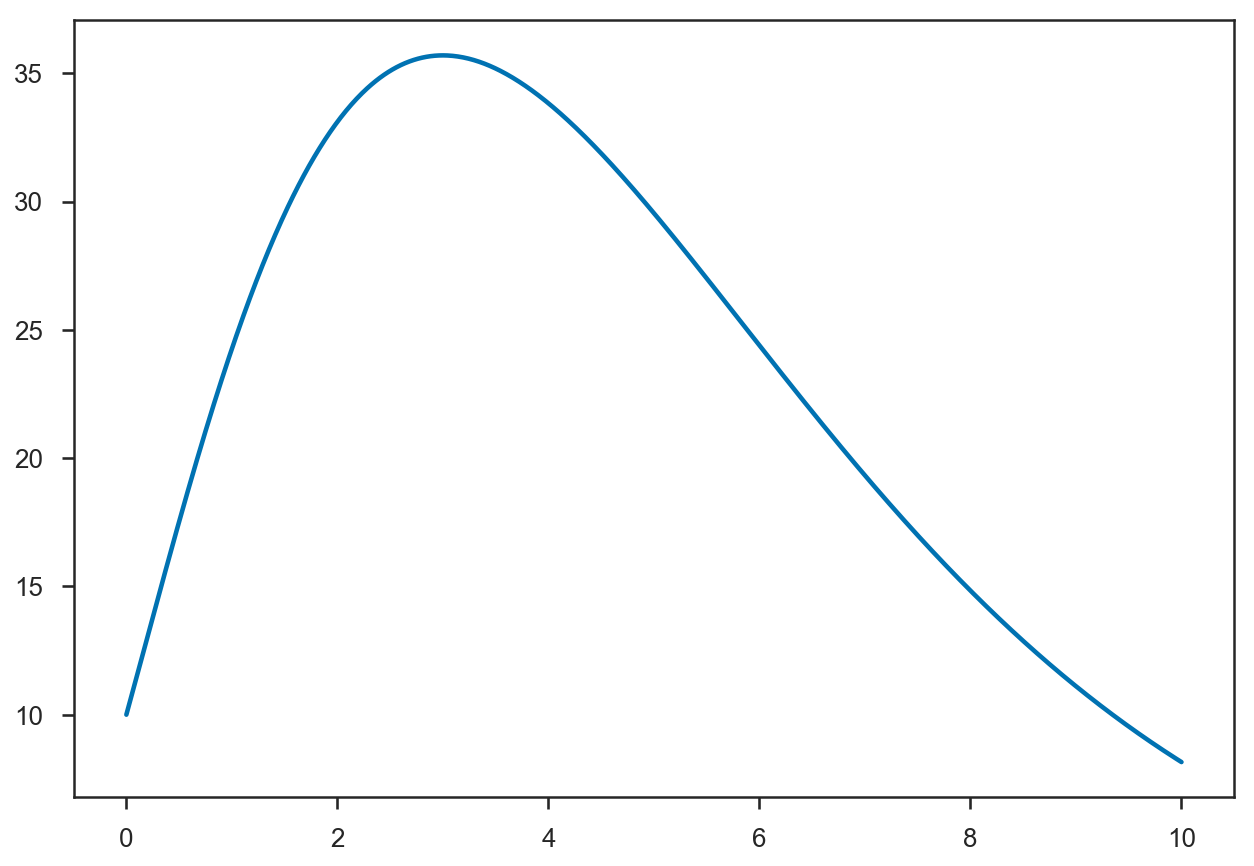

In [21]:
plot(zs, dNdz(zs, Ntrue, alphatrue, betatrue))

We will need to draw from this distribution; the code below uses the Python `yield` statement to produce a generator that generates events from this distribution.  We draw the events using von Neumann rejection sampling, and restrict the redshift range to $0 \leq z \leq 10$.

In [22]:
def draw_zs(N0, alpha, beta):
    zs = linspace(0, 10, 1000)
    dndzs = dNdz(zs, N0, alpha, beta)
    ymax = np.max(dndzs)
    Nex = trapz(dndzs, zs)
    Ndraw = random.poisson(Nex)
    igen = 0
    while igen < Ndraw:
        y = random.uniform(low=0, high=ymax)
        z = random.uniform(low=0, high=10)
        if y < dNdz(z, N0, alpha, beta):
            igen += 1
            yield z

Let's check that the distribution of draws is correct:

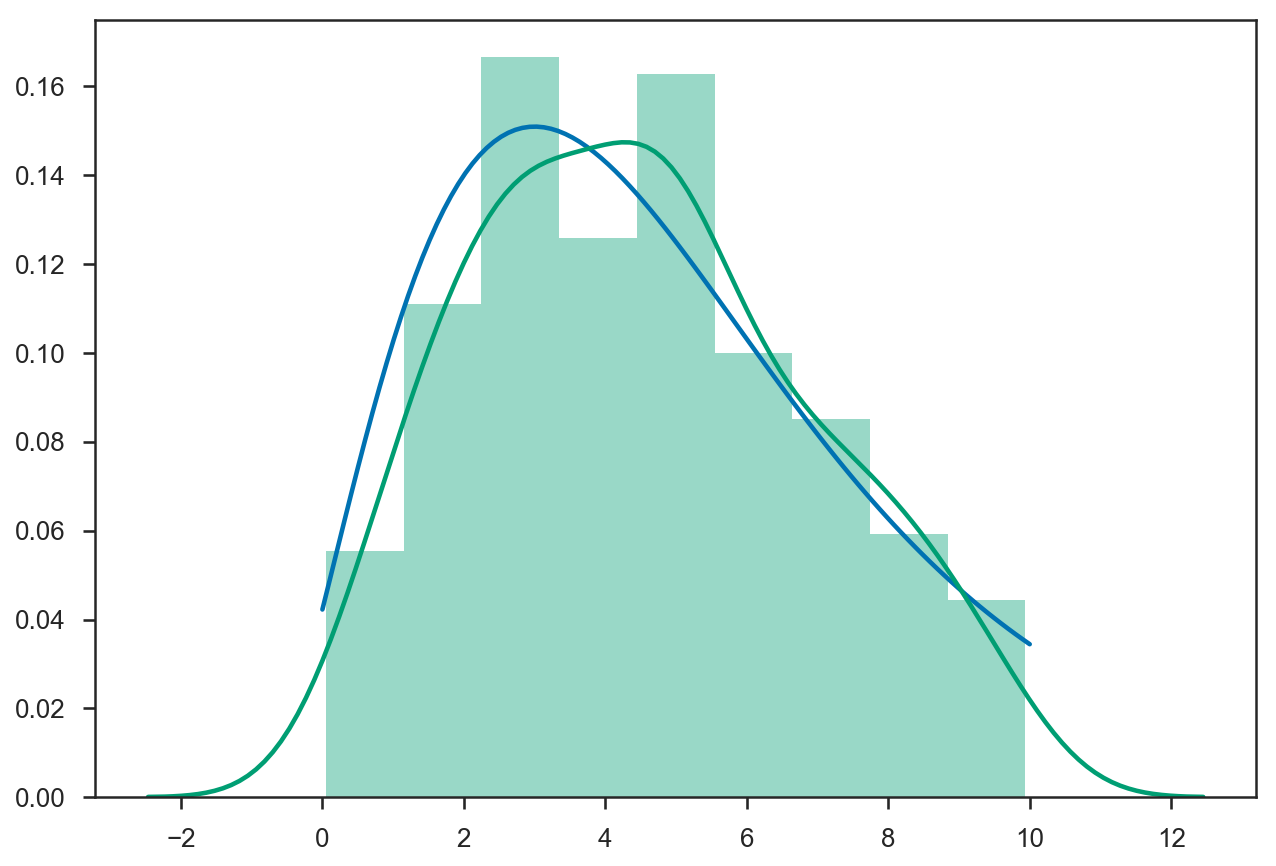

In [25]:
zs = linspace(0, 10, 100)
plot(zs, dNdz(zs, Ntrue, alphatrue, betatrue)/Nextrue)
sns.distplot([z for z in draw_zs(Ntrue, alphatrue, betatrue)])

Now we build the Stan model that uses the above likelihood.  There is a trick to get stan to compute the expected number of events: Stan doesn't (directly) do integrals like 
$$
N\left( \boldsymbol{\lambda} \right) = \int \mathrm{d} \boldsymbol{\theta} \frac{\mathrm{d} N}{\mathrm{d} \boldsymbol{\theta}}\left(\boldsymbol{\theta} \mid \boldsymbol{\lambda}\right),
$$
but it *does* know how to solve ODEs, so we set up an ODE whose solution is the integral and get Stan to solve it.

Also, we use the `generated quantities` block to generate the rate function $\mathrm{d}N/\mathrm{d}\boldsymbol{\theta}$ at chosen values of $z$ every time a set of parameters are output (this is distinguished from `transformed parameters` by not being computed for every *internal* step of the Stan sampler, but only when values are being output).

In [31]:
model_direct = pystan.StanModel(file='zmodel_direct.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6ec91185416620b317ec80af34f4a412 NOW.


In [93]:
ztrues = [z for z in draw_zs(Ntrue, alphatrue, betatrue)]

In [94]:
data_direct = {
    'nobs': len(ztrues),
    'zobs': ztrues,
    'nmodel': 100,
    'zs_model': linspace(0, 10, 100)
}

In [95]:
fit_direct = model_direct.sampling(data=data_direct)

Inference for Stan model: anon_model_6ec91185416620b317ec80af34f4a412.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
N0              12.16    0.14    3.6   6.34   9.59  11.72  14.36  20.17    701    1.0
alpha             1.7    0.02   0.41    0.9   1.42   1.69   1.99   2.51    629    1.0
beta             2.44    0.02   0.59   1.67   2.04   2.33    2.7   3.94    597    1.0
dNdz_model[0]   12.16    0.14    3.6   6.34   9.59  11.72  14.36  20.17    701    1.0
dNdz_model[1]    13.6    0.13   3.63   7.54  11.02   13.2  15.88  21.49    723    1.0
dNdz_model[2]   15.03    0.13   3.63   8.79  12.44  14.64  17.38  22.74    748    1.0
dNdz_model[3]   16.42    0.13    3.6  10.08  13.87   16.1  18.77  24.06    777    1.0
dNdz_model[4]   17.79    0.12   3.55  11.41  15.31  17.47  20.16  25.36    812    1.0
dNdz_model[5]    19.1    0.12   3.49 

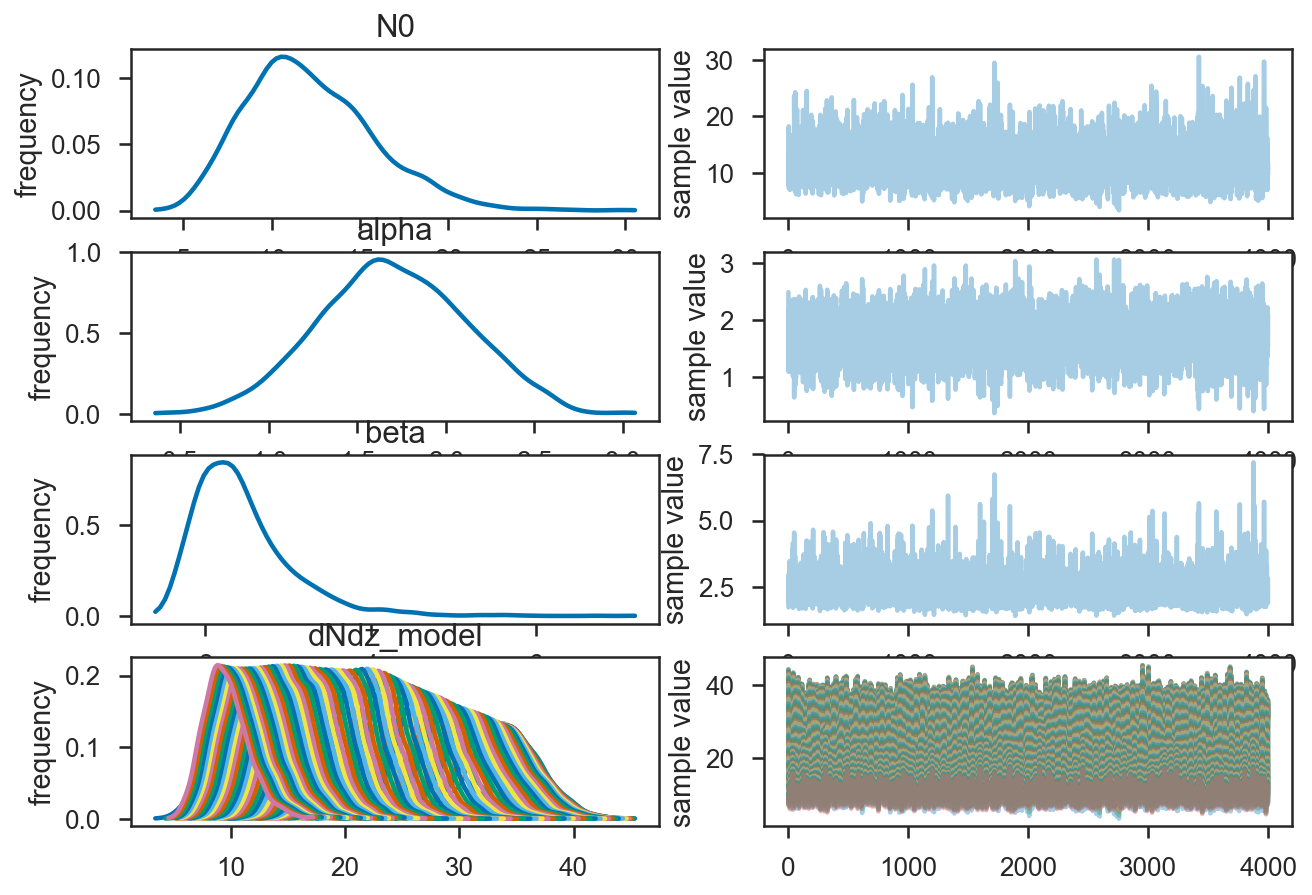

In [96]:
fit_direct.plot()
fit_direct

In [97]:
chain_direct = fit_direct.extract(permuted=True)

How does the fit look?  Pretty good.  I realise this may not seem like a big deal, but it is fairly rare in the astro literature to see a fit like this *without binning* (right?).

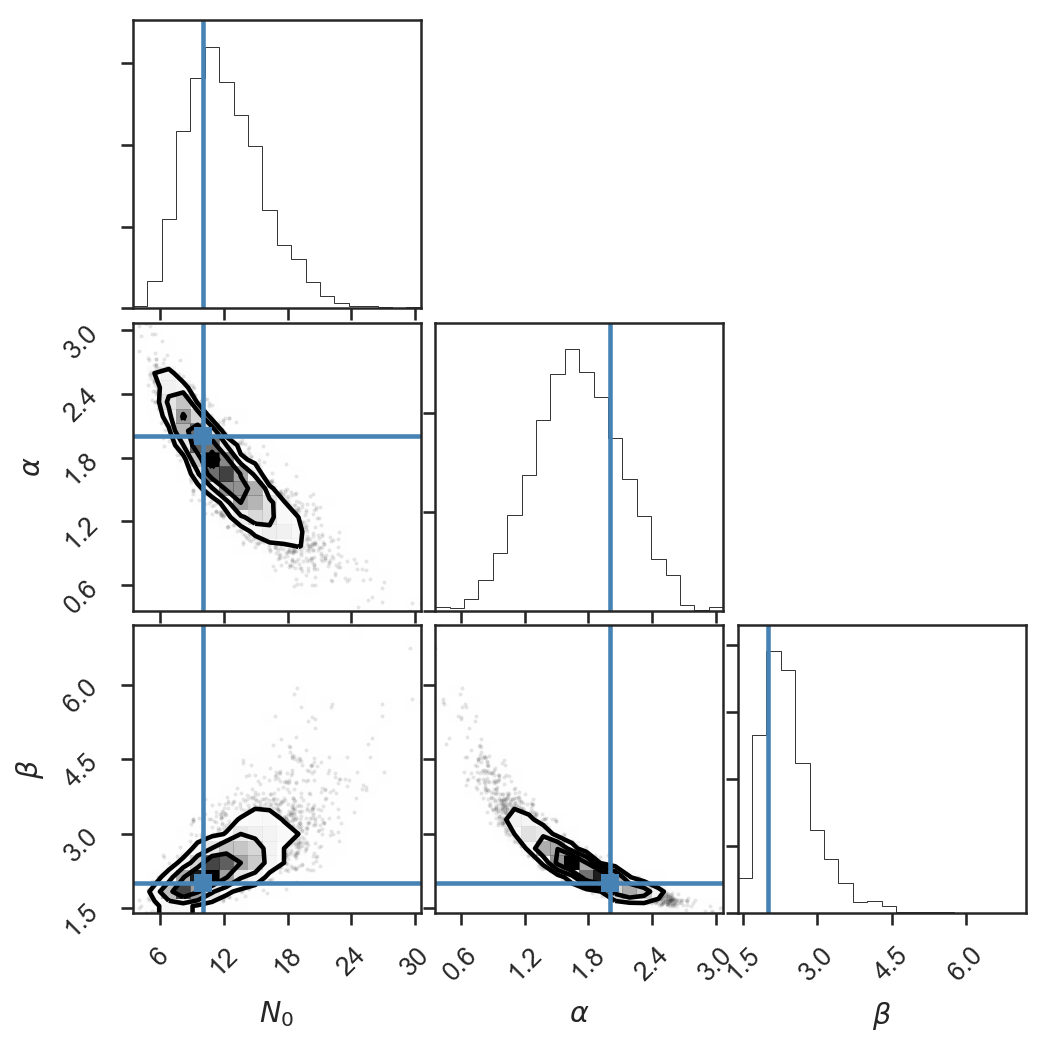

In [98]:
corner.corner(
    column_stack([chain_direct[key] for key in ['N0', 'alpha', 'beta']]),
    labels=[r'$N_0$', r'$\alpha$', r'$\beta$'],
    truths=[Ntrue, alphatrue, betatrue]
);

#### Imperfect Redshift Measurements

OK.  Now let's be a bit more realistic.  First, it is not reasonble to expect our hypothetical LIGO to measure the redshift perfectly.  How should we handle this?  We can introduce a $z_\mathrm{obs}$ for each event which will become the data (before the data was the true redshift, $z$), and let's imagine they are related by 
$$
\log z_\mathrm{obs} \sim N\left( \log z , \sigma_z \right),
$$
with $\sigma_z = 0.2$ (i.e. our hypothetical IFO has 20% uncertainty in its measurements of redshift).  

What should the likelihood look like now?  Well, the rate still applies to the true redshift, $z$, but we now need a term that gives $p\left( z_\mathrm{obs} \mid z \right)$, or, in $z = \boldsymbol{\theta}$, $z_\mathrm{obs} = d$ language:
$$
p\left( \left\{ d^{(i)}, \boldsymbol{\theta}^{(i)} \right\} \mid \lambda \right) = \prod_i \left[ p\left( d^{(i)} \mid \boldsymbol{\theta}^{(i)} \right) \frac{\mathrm{d} N}{\mathrm{d} \boldsymbol{\theta}} \left( \boldsymbol{\theta}^{(i)} \mid \boldsymbol{\lambda} \right) \right] \exp\left( - \int \mathrm{d} \boldsymbol{\theta} \frac{\mathrm{d} N}{\mathrm{d} \boldsymbol{\theta}}\left(\boldsymbol{\theta} \mid \boldsymbol{\lambda}\right) \right)
$$
The term $p\left( d^{(i)} \mid \boldsymbol{\theta}^{(i)} \right)$ (which, in our case, is a log-normal distribution for $z_\mathrm{obs}$ given $z$ and $\sigma$) is the likelihood function that would figure prominently in a "parameter estimation" analysis.

Let's fit this new model. (By the way, notice how the dimensionality of the model has gone up significantly---each observation introduces a new parameter---which can make sampling very hard for some samplers.  Fortunately, Stan tends to perform well in high-dimensional sampling problems.)

In [135]:
model_errors = pystan.StanModel(file='zmodel_errors.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a186163caf98c9b165fe6fe5687ae76d NOW.


Let's draw some "observations" from the same set of true redshifts we had before:

In [188]:
zobs = []
sigma = []
for z in ztrues:
    s = 0.2
    zo = exp(log(z) + s*randn())
    zobs.append(zo)
    sigma.append(s)

In [189]:
data_errors = {
    'nobs': len(zobs),
    'zobs': zobs,
    'sigmaobs': sigma,
    'nmodel': 100,
    'zs_model': linspace(0,10,101)[1:] # The code will give NaNs at z == 0.
}

In [190]:
fit_errors = model_errors.sampling(data=data_errors)

In [191]:
fit_errors

Inference for Stan model: anon_model_a186163caf98c9b165fe6fe5687ae76d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
N0              10.47    0.07   3.33   5.03   8.07  10.11  12.39  17.91   1989    1.0
alpha            1.98    0.01   0.47   1.12   1.64   1.96   2.28   2.95   1710    1.0
beta             2.13    0.01   0.49   1.42   1.79   2.04   2.38   3.34   1740    1.0
ztrue[0]         0.53  1.7e-3   0.11   0.36   0.46   0.52    0.6   0.76   4000    1.0
ztrue[1]         4.18    0.01   0.82   2.84   3.59   4.09   4.69   6.02   4000    1.0
ztrue[2]         7.14    0.02   1.22   4.92   6.25   7.11   8.03    9.5   4000    1.0
ztrue[3]         6.08    0.02   1.15   4.11   5.27   5.99   6.82   8.58   4000    1.0
ztrue[4]         7.12    0.02   1.23   4.88   6.22   7.07   8.02   9.58   4000    1.0
ztrue[5]         0.74  2.4e-3   0.15 

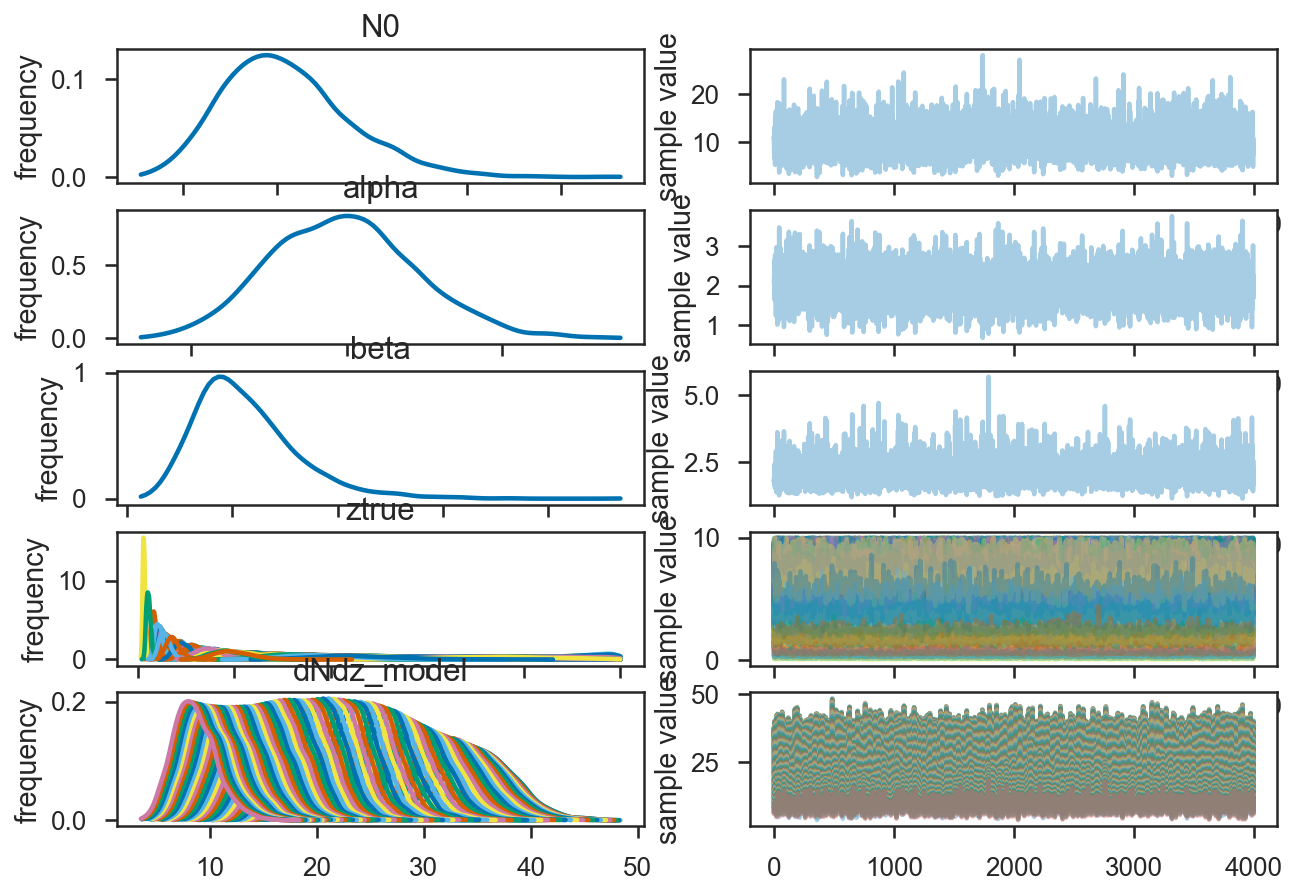

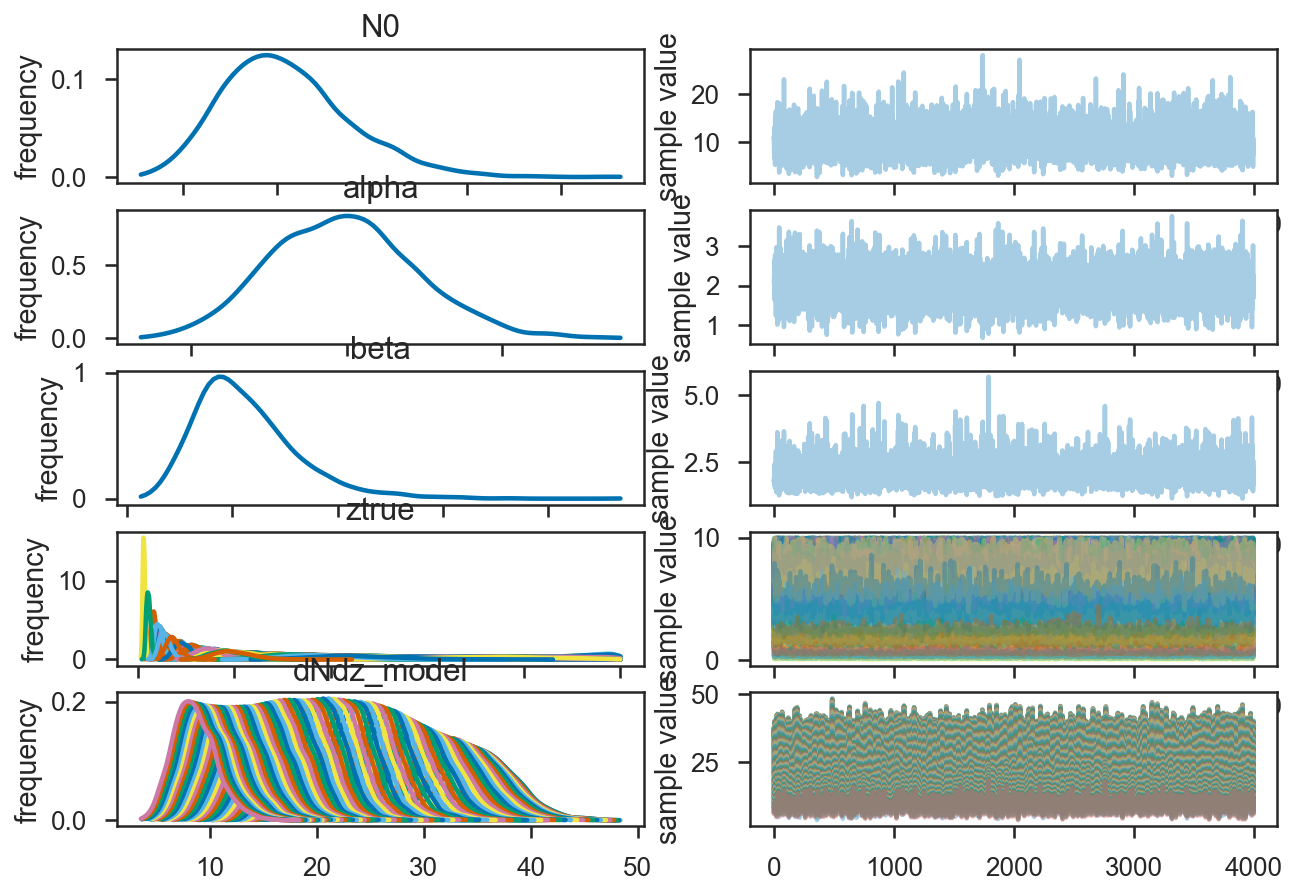

In [192]:
fit_errors.plot()

In [193]:
chain_errors = fit_errors.extract(permuted=True)

Let's have a look at the inference for a random $z$.  The solid line is $z_\mathrm{obs}$, the dashed line is $z_\mathrm{true}$, and the distribution is $p\left( z_\mathrm{true} \mid z_\mathrm{obs}, N_0, \alpha, \beta \right)$.

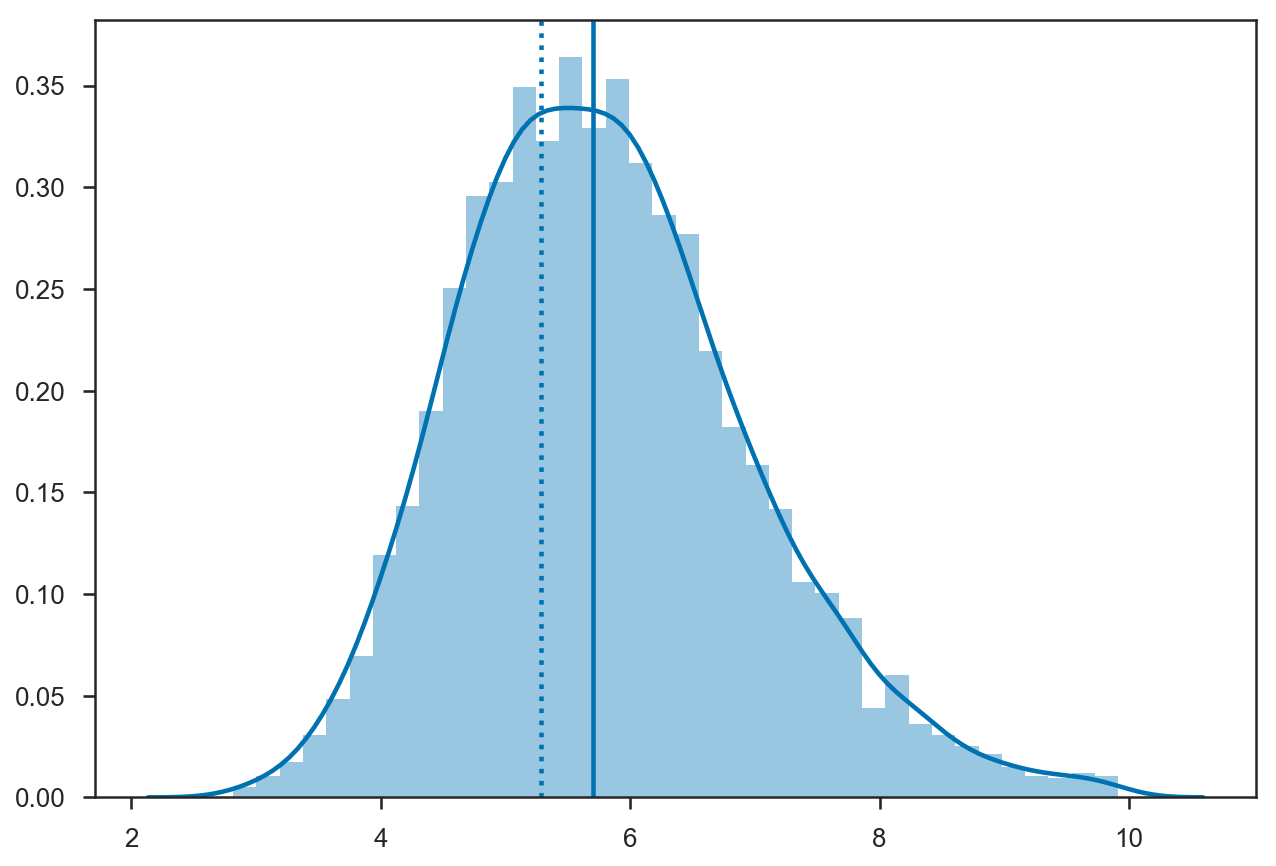

In [194]:
i = randint(len(zobs))
sns.distplot(chain_errors['ztrue'][:,i])
axvline(zobs[i])
axvline(ztrues[i], ls=':')

And how about the inference for the population parameters?  It looks pretty good, though the uncertainties are a bit larger than in the previous fit, since we don't measure the redshifts perfectly any more.

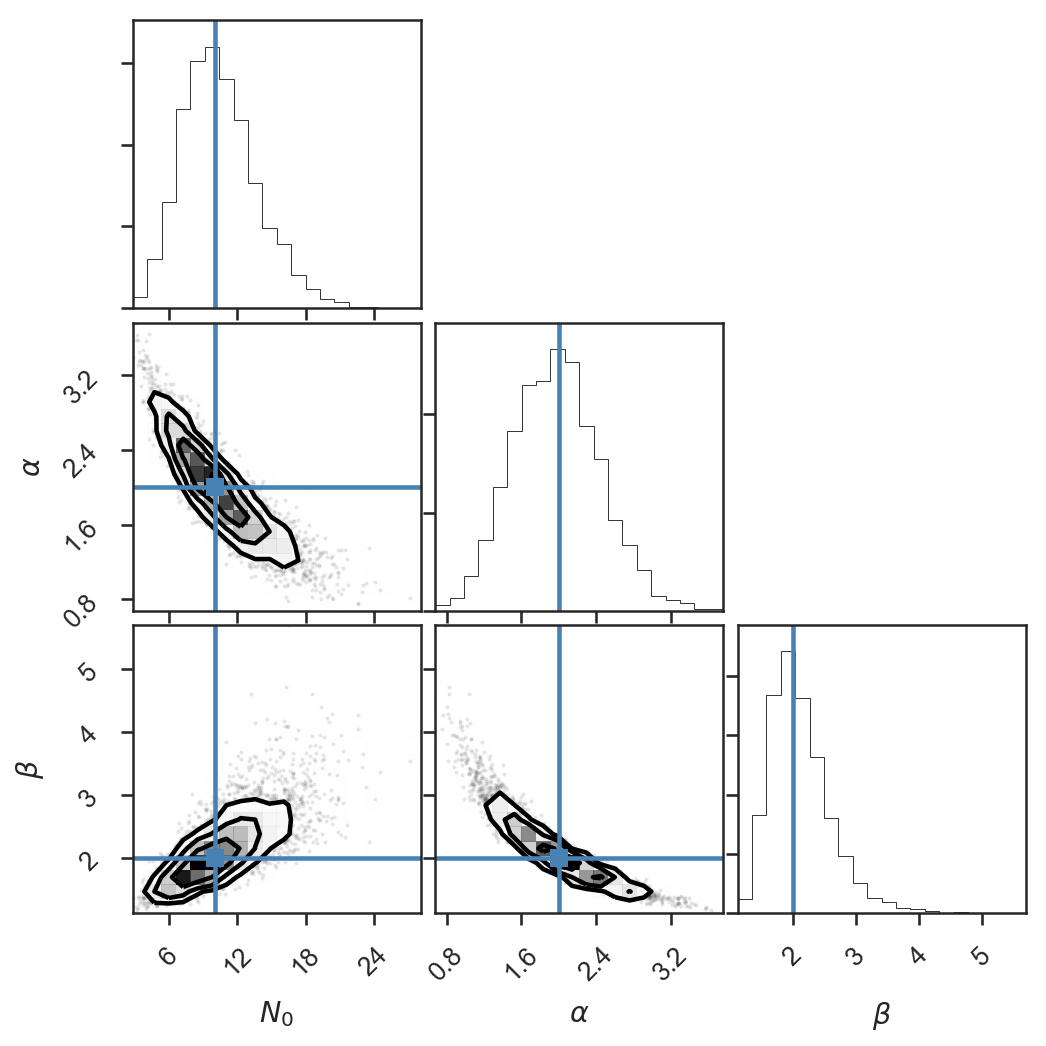

In [199]:
corner.corner(
    column_stack([chain_errors[key] for key in ['N0', 'alpha', 'beta']]),
    labels=[r'$N_0$', r'$\alpha$', r'$\beta$'],
    truths=[Ntrue, alphatrue, betatrue]
);

The whole reason we generated the $\mathrm{d}N/\mathrm{d}z$ curves was to make this plot.  We have in black the true redshift distribution, and in blue the fitted one.  The line gives the posterior median value, and the dark and light bands give $1\sigma$ and $2\sigma$ (68% and 95%) credible intervals.  For this particular data set we have gotten particularly lucky, and the median value is very close to the black line; repeating the fit with different data (try it!) will cause the fit to move around and we won't usually be this lucky (but it will be rare for the truth to lie outside the $1\sigma$ and rarer still for it to lie outside the $2\sigma$ contours).

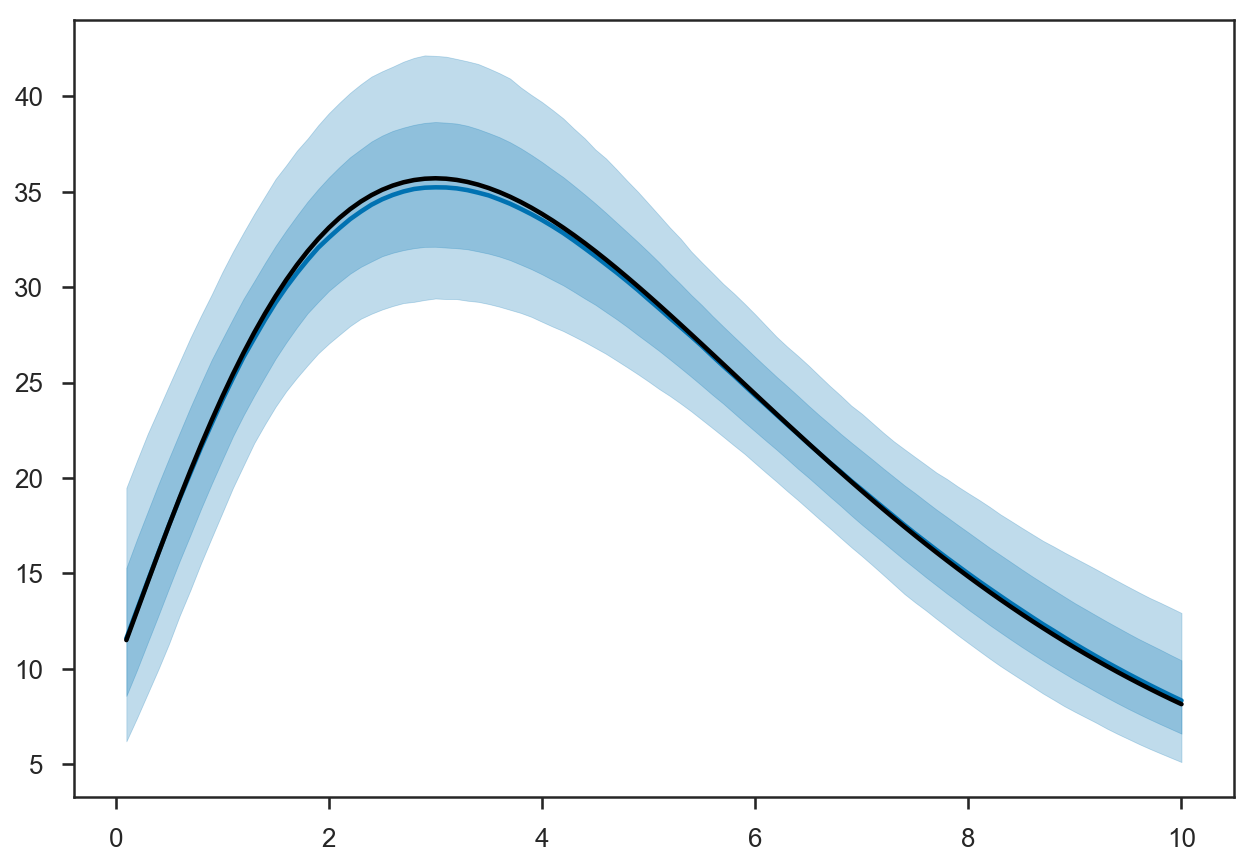

In [200]:
plot(data_errors['zs_model'], median(chain_errors['dNdz_model'], axis=0))
fill_between(data_errors['zs_model'], percentile(chain_errors['dNdz_model'], 84, axis=0), percentile(chain_errors['dNdz_model'], 16, axis=0), color=sns.color_palette()[0], alpha=0.25)
fill_between(data_errors['zs_model'], percentile(chain_errors['dNdz_model'], 97.5, axis=0), percentile(chain_errors['dNdz_model'], 2.5, axis=0), color=sns.color_palette()[0], alpha=0.25)
plot(data_errors['zs_model'], dNdz(data_errors['zs_model'], Ntrue, alphatrue, betatrue), '-k')

#### Down-Selected Imperfect Redshift Measurements

Let us suppose that our LIGO detector cannot measure signals at all redshifts (see above regarding the current range of Advanced LIGO; and note that even at design sensitivity the horizon distance is $z \simeq 1$ for BBH).  To model this effect, we imagine that the detector can see an event only if $z_\mathrm{obs} \leq 6$ (obviously this is optimistic for aLIGO, but bear with me). 

Note that the selection is applied *to the data*, not to the parameters.  This is a realistic model for the functioning of a real detector; we filter data streams to find triggers for events.  In fact, I cannot think of a pipeline that would use the true parameters to filter events---we don't *know* the true parameters, so how can we filter on them.  The seemingly simple idea that the selection depends on the data leads to some counter-intuitive consequences in the likelihood function that we will use; for a fuller explanation of this effect, see [Loredo (2004)](https://ui.adsabs.harvard.edu/#abs/2004AIPC..735..195L/abstract), [Mandel, Farr & Gair (2016)](https://dcc.ligo.org/LIGO-P1600187/public), or the appendices of [Abbott, et al. (2016)](https://ui.adsabs.harvard.edu/#abs/2016PhRvX...6d1015A/abstract).

Our selection function will do three things:

 1. It will add a term $P_\mathrm{det}\left( d \mid \boldsymbol{\lambda} \right)$ to the likelihood for each source.  This is a term that would allow us to *fit* for the selection function (see, e.g. [Farr, et al. (2014)](https://ui.adsabs.harvard.edu/#abs/2014arXiv1412.4849F/abstract)). by including parameters describing it in $\boldsymbol{\lambda}$.  Here we will not be doing this; we will just treat the threshold redshift of $z = 6$ as known.
 1. It will change the expected number of sources that goes in the exponential; we now need to do a double-integral over both source parameters and the data generated from those parameters to determine what fraction of sources will be detected:
 $$
 N\left(\boldsymbol{\lambda} \right) = \int \mathrm{d} d \, \mathrm{d}\boldsymbol{\theta} \, P_\mathrm{det}\left( d \mid \boldsymbol{\lambda} \right) p\left( d \mid \boldsymbol{\theta} \right) \frac{\mathrm{d}N}{\mathrm{d} \boldsymbol{\theta}} \left( \boldsymbol{\theta} \mid \boldsymbol{\lambda} \right).
 $$
 In our simple example, $P_\mathrm{det}$ is independent of $\boldsymbol{\lambda}$, and we can do the integral over data, $d$, analytically.  The result is 
 $$
 N\left(\boldsymbol{\lambda} \right) = \int \mathrm{d}\boldsymbol{\theta} \, \bar{P}_\mathrm{det} \left( \boldsymbol{\theta} \right) \frac{\mathrm{d}N}{\mathrm{d} \boldsymbol{\theta}} \left( \boldsymbol{\theta} \mid \boldsymbol{\lambda} \right),
 $$
 with 
 $$
 \DeclareMathOperator{\erfc}{erfc}
 \bar{P}_\mathrm{det} \left(\boldsymbol{\theta} \right) = \frac{1}{2} \erfc \left(\frac{5 \left( \log z_\mathrm{true} - \log 6\right)}{\sqrt{2}} \right)
 $$
 being the fraction of the log-normal data distribution for parameter $z_\mathrm{true}$ with $z_\mathrm{obs} < 6$.
 
Putting everything together, we finally arrive at the equation referenced above, the "fundamental equation of populations":
$$
p\left( \left\{ d^{(i)}, \boldsymbol{\theta^{(i)}} \right\} \mid \boldsymbol{\lambda} \right) = \left[ \prod_{i} P_\mathrm{det}\left( d^{(i)} \mid \boldsymbol{\lambda} \right) p\left( d^{(i)} | \boldsymbol{\theta}^{(i)} \right) \frac{\mathrm{d} N}{\mathrm{d} \boldsymbol{\theta}}\left( \boldsymbol{\theta}^{(i)} \mid \boldsymbol{\lambda} \right) \right] \exp\left[ - \int \mathrm{d} d \mathrm{d}\boldsymbol{\theta} P_\mathrm{det}\left( d \mid \boldsymbol \lambda \right) p\left( d \mid \boldsymbol{\theta} \right) \frac{\mathrm{d}N}{\mathrm{d} \boldsymbol{\theta}}\left( \boldsymbol{\theta} \mid \lambda \right) \right].
$$

Something to note, because it is subtle: one might ask, why don't we just fit for the *downselected* distribution of source parameters,
$$
\bar{P}_\mathrm{det} \left( \boldsymbol{\theta} \right) \frac{\mathrm{d} N}{\mathrm{d} \boldsymbol{\theta}},
$$
using one of the formalisms above (either with or without errors)?
After all, that is what the observable distribution of $\theta$ "looks like."  The reason is that this corresponds to a "just so" story where our pipelines select on *the true parameters*, $\boldsymbol{\theta}$.  But these parameters are *almost never* accessible to our pipelines; rather, they look at the data, and make a decision whether to flag something as a "detection" or not.  Since the selection is done on the data, it is not appropriate to try to modify the distribution of *parameters* appearing in the likelihood.

OK.  Let's get fitting.

The probability that a source at redshift `ztrue` will be detected:

In [226]:
def Pbar_det(ztrue):
    return 0.5*sp.erfc(5*(log(ztrue)-log(6))/sqrt(2))

Compile our Stan model:

In [243]:
model_selected = pystan.StanModel(file='zmodel_selected.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_819686cb66fbfca4816662b30d71cdeb NOW.


Now we down-select our data set:

In [244]:
zobs_selected = []
sigma_selected = []
for zo, s in zip(zobs, sigma):
    if zo < 6:
        zobs_selected.append(zo)
        sigma_selected.append(s)
print('Selected {:d} out of {:d} sources'.format(len(zobs_selected), len(zobs)))

Selected 170 out of 237 sources


Just to check that the distribution is reasonable:

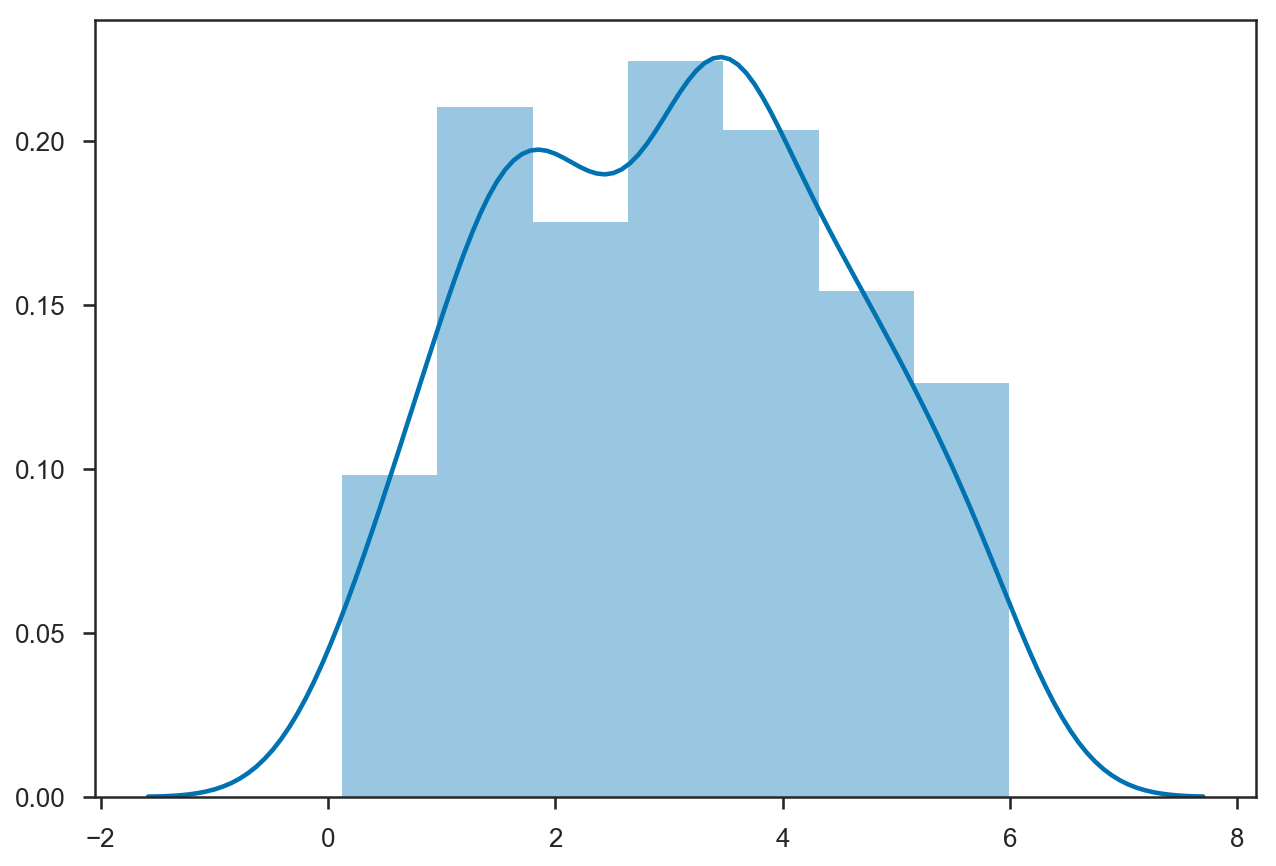

In [245]:
sns.distplot(zobs_selected)

It is helpful, in considering what our fit might look like now (i.e. what uncertainties we might find, etc), to plot the distribution of true redshifts and the distribution of redshifts that would be found in selected sources.  These differ by a factor of $\bar{P}_\mathrm{dec}(z)$.  (Again, note that we aren't *fitting* for the down-selected population directly.)  For example, if the location of the peak moved signifcantly due to the selection, we might have trouble fitting for the parameter $\beta$ since it controls the location of the peak.

Note that the expected number of detected events matches well with our expectation above.

I expected 237 sources in total, but to detect only 174.


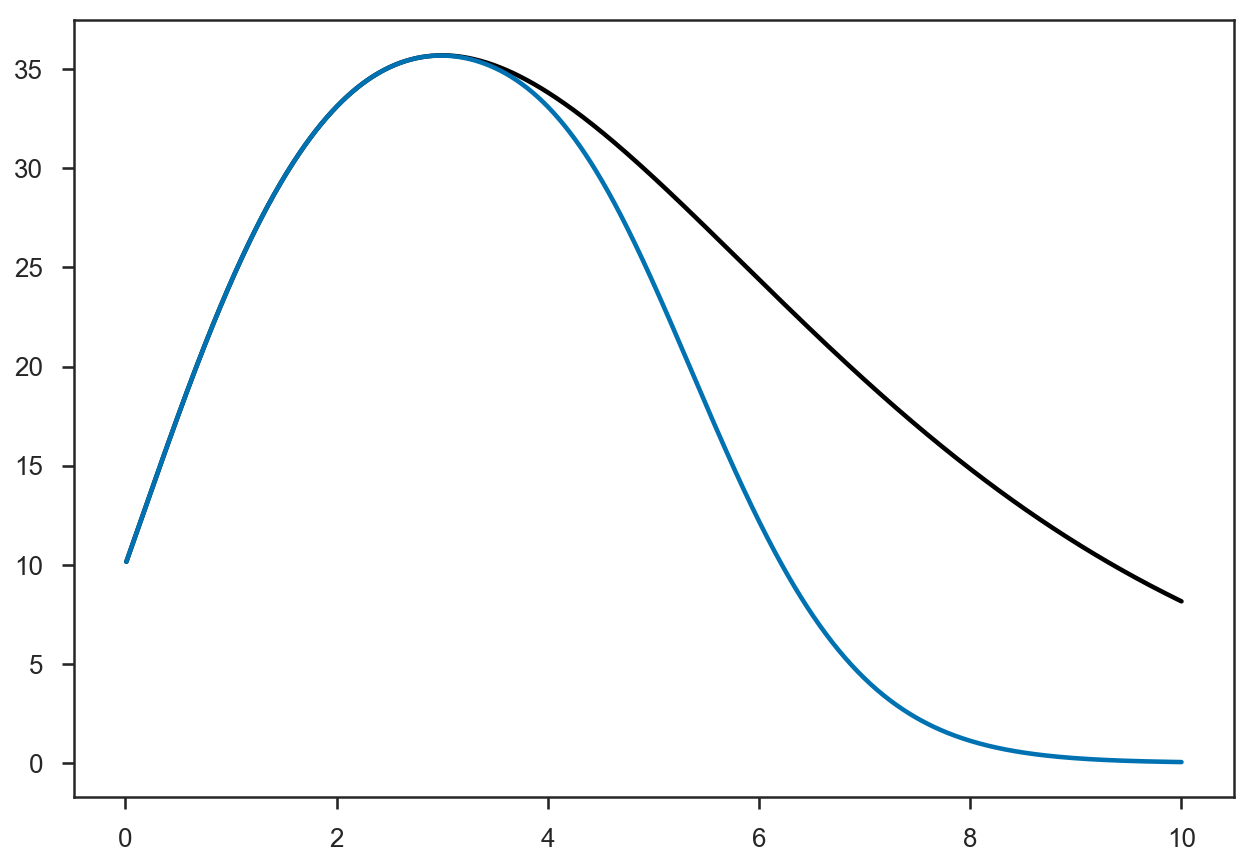

In [246]:
zs = linspace(0, 10, 1000)[1:]
dNdz_true = dNdz(zs, Ntrue, alphatrue, betatrue)
dNdz_selected = dNdz_true*Pbar_det(zs)
plot(zs, dNdz_true, '-k', label='True')
plot(zs, dNdz_selected, label='Selected')
print('I expected {:.0f} sources in total, but to detect only {:.0f}.'.format(trapz(dNdz_true, zs), trapz(dNdz_selected, zs)))

In [247]:
data_selected = {
    'nobs': len(zobs_selected),
    'zobs': zobs_selected,
    'sigmaobs': sigma_selected,
    'nmodel': 100,
    'zs_model': linspace(0,10,101)[1:]
}

In [248]:
fit_selected = model_selected.sampling(data=data_selected)

In [249]:
fit_selected

Inference for Stan model: anon_model_819686cb66fbfca4816662b30d71cdeb.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
N0               9.23     0.1   3.55   3.65   6.73   8.69  11.26  17.35   1352    1.0
alpha            2.44    0.03   0.77    1.1    1.9    2.4   2.92   4.07    742    1.0
beta             1.76    0.02   0.77   0.91   1.28   1.58   2.03   3.75   1230    1.0
ztrue[0]         0.53  1.7e-3   0.11   0.35   0.46   0.52    0.6   0.79   4000    1.0
ztrue[1]         4.13    0.01    0.8   2.79   3.57   4.06   4.62   5.89   4000    1.0
ztrue[2]         0.74  2.4e-3   0.15   0.49   0.64   0.73   0.83   1.08   4000    1.0
ztrue[3]          5.1    0.02   0.98   3.38    4.4   5.01    5.7   7.25   4000    1.0
ztrue[4]          4.7    0.01   0.94   3.15   4.03    4.6   5.28    6.8   4000    1.0
ztrue[5]         1.62  5.1e-3   0.32 

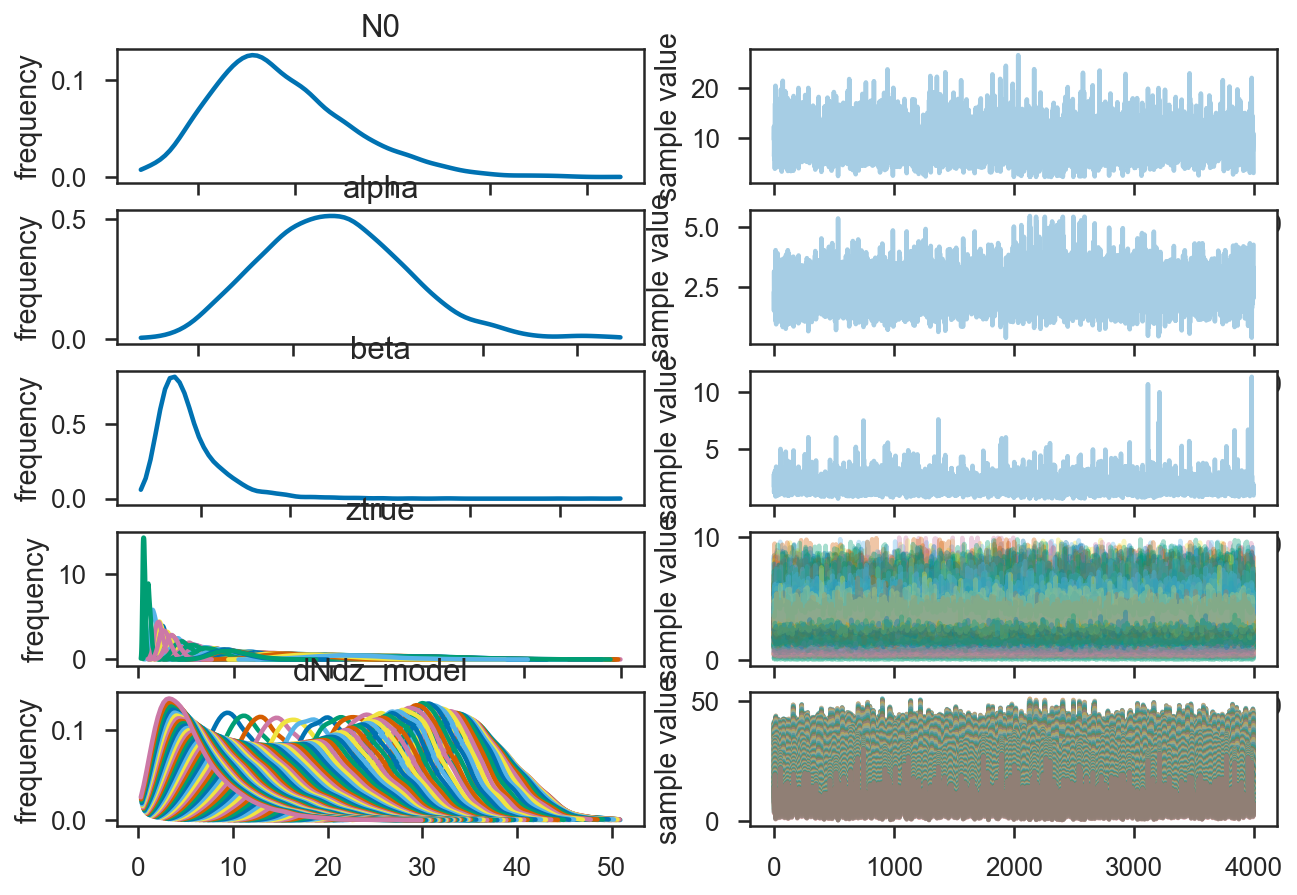

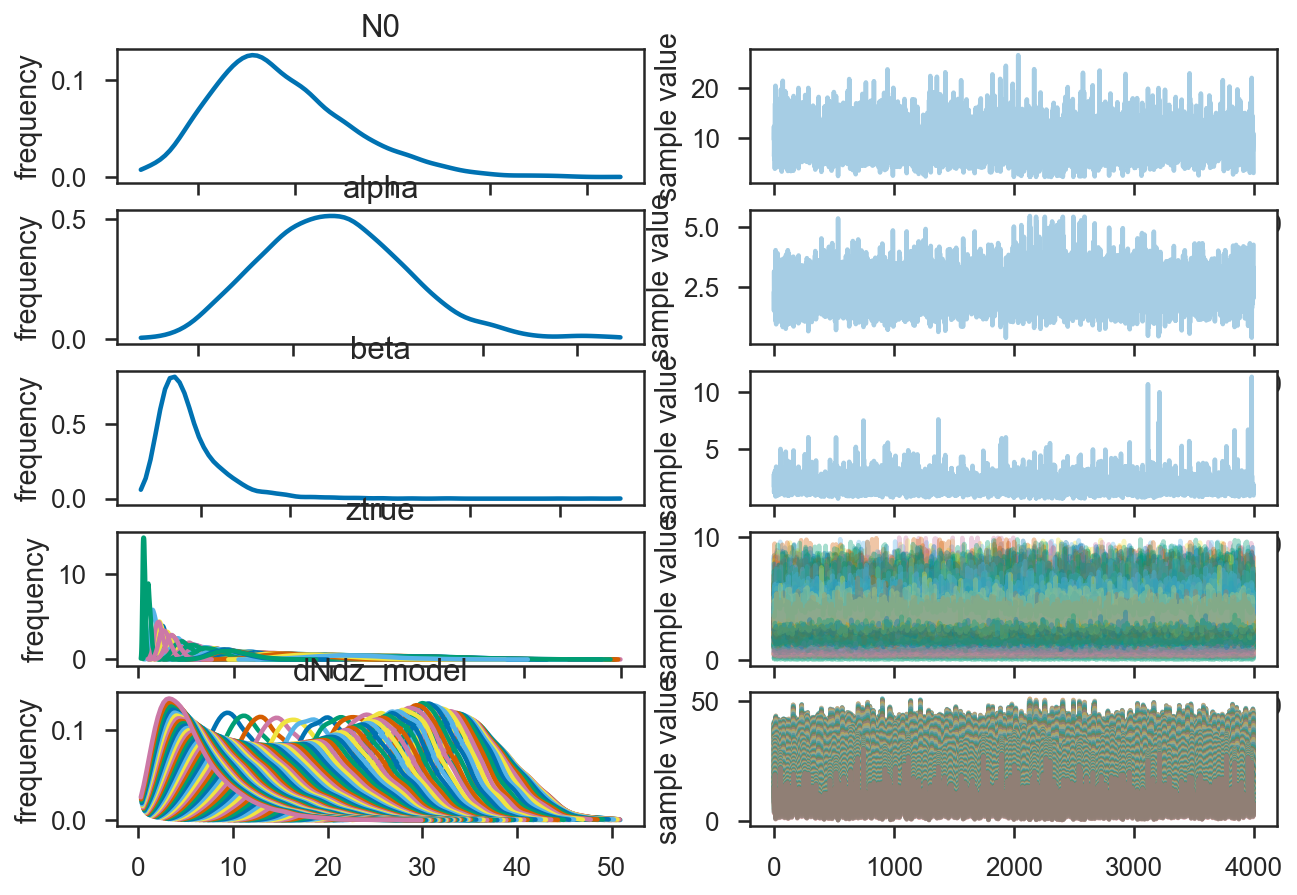

In [250]:
fit_selected.plot()

In [251]:
chain_selected = fit_selected.extract(permuted=True)

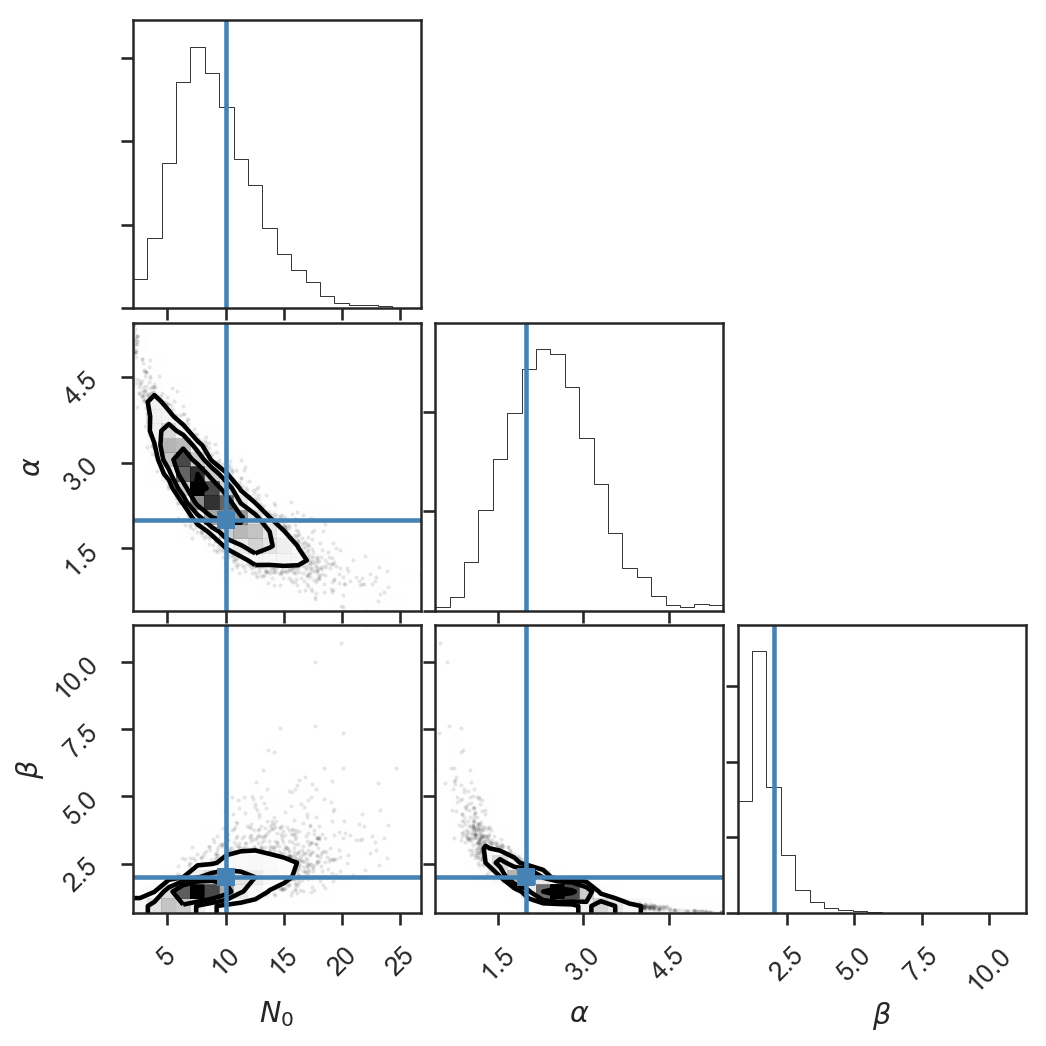

In [252]:
corner.corner(
    column_stack([chain_selected[key] for key in ['N0', 'alpha', 'beta']]),
    labels=[r'$N_0$', r'$\alpha$', r'$\beta$'],
    truths=[Ntrue, alphatrue, betatrue]
);

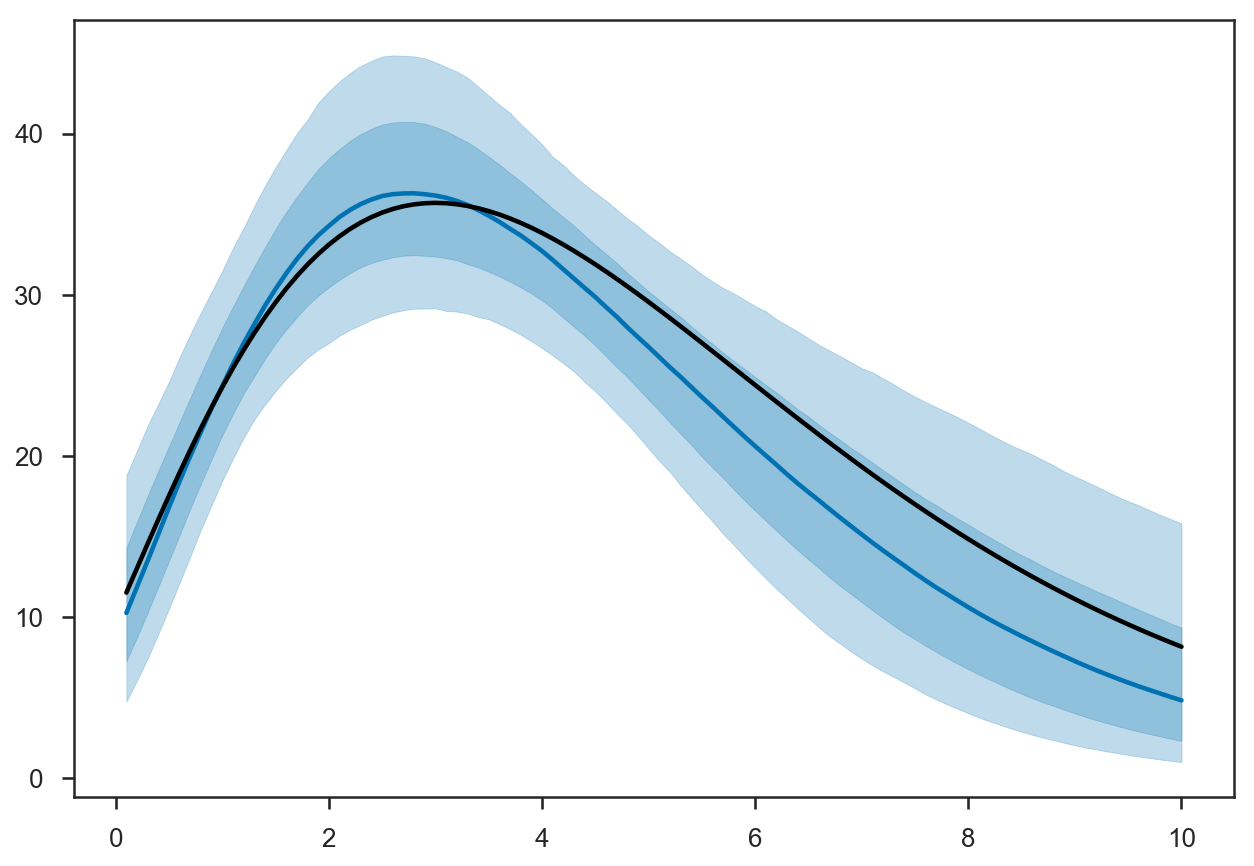

In [253]:
plot(data_selected['zs_model'], median(chain_selected['dNdz_model'], axis=0))
fill_between(data_selected['zs_model'], percentile(chain_selected['dNdz_model'], 84, axis=0), percentile(chain_selected['dNdz_model'], 16, axis=0), color=sns.color_palette()[0], alpha=0.25)
fill_between(data_selected['zs_model'], percentile(chain_selected['dNdz_model'], 97.5, axis=0), percentile(chain_selected['dNdz_model'], 2.5, axis=0), color=sns.color_palette()[0], alpha=0.25)
plot(data_selected['zs_model'], dNdz(data_selected['zs_model'], Ntrue, alphatrue, betatrue), '-k')